In [1]:

import sys
sys.path.append('../')
from fit.datamodules.super_res import MNIST_SResFITDM
from fit.utils.tomo_utils import get_polar_rfft_coords_2D

from fit.modules.SResTransformerModule import SResTransformerModule

from matplotlib import pyplot as plt
from matplotlib import gridspec
from fit.utils import PSNR

import torch

import numpy as np
import pandas as pd
from pytorch_lightning import Trainer, seed_everything
from pytorch_lightning.callbacks import ModelCheckpoint
from pytorch_lightning.loggers import WandbLogger

from os.path import exists
import wget
import ssl
ssl._create_default_https_context = ssl._create_unverified_context
import scipy

/home/aman.kukde/miniforge3/envs/fit/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
seed_everything(22122020)

Seed set to 22122020


22122020

In [3]:
dm = MNIST_SResFITDM(root_dir='./datamodules/data/', batch_size=32)
dm.prepare_data(subset_flag=False)
dm.setup()

In [4]:
r, phi, flatten_order, order = get_polar_rfft_coords_2D(img_shape=dm.gt_shape)

In [5]:
n_heads = 8
d_query = 32

In [6]:
model = SResTransformerModule(d_model=n_heads*d_query, 
                              img_shape=dm.gt_shape,
                              coords=(r, phi),
                              dst_flatten_order=flatten_order,
                              dst_order=order,
                              loss='sum',
                              lr=0.0001, weight_decay=0.01, n_layers=8,
                              n_heads=n_heads, d_query=d_query, dropout=0.1, attention_dropout=0.1,num_shells = 4,
                              model_path ='')
import datetime

# Train your own model.
name = datetime.datetime.now().strftime("%d-%m_%H-%M-%S")
wandb_logger = WandbLogger(name = f'Run_{name}',project="MNIST",save_dir=f'/home/aman.kukde/Projects/Super_Resolution_Task/Original_FIT/FourierImageTransformer/saved_models/{name}',log_model="all")
trainer = Trainer(max_epochs=100,logger=wandb_logger,
                  enable_checkpointing=True,default_root_dir = f'/home/aman.kukde/Projects/Super_Resolution_Task/Original_FIT/FourierImageTransformer/saved_models/{name}', 
                                            callbacks=ModelCheckpoint(
                                            dirpath=f'/home/aman.kukde/Projects/Super_Resolution_Task/Original_FIT/FourierImageTransformer/saved_models/{name}',
                                            save_top_k=1,
                                            verbose=False,
                                            save_last=True,
                                            monitor='Validation/avg_val_loss',
                                            # mode='min'),limit_train_batches= 0.1,fast_dev_run=True)
                                            mode='min'))#,limit_train_batches= 0.1,fast_dev_run=True)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [7]:
# trainer = Trainer(max_epochs=100, 
#                   gpus=1, # set to 0 if you want to run on CPU
#                   callbacks=ModelCheckpoint(
#                                             dirpath=None,
#                                             save_top_k=1,
#                                             verbose=False,
#                                             save_last=True,
#                                             monitor='Train/avg_val_loss',
#                                             mode='min'
#                                         ), 
#                   deterministic=True)

In [8]:
# Train your own model.
# trainer.fit(model, datamodule=dm);

In [9]:
# if not exists('./models/sres/mnist_sres.ckpt'):
#     wget.download('https://download.fht.org/jug/fit/sres_model_mnist.ckpt',
#                   out='./models/sres/mnist_sres.ckpt')

In [10]:
model.load_test_model('/home/aman.kukde/Projects/Super_Resolution_Task/Original_FIT/FourierImageTransformer/saved_models/22-02_14-03-44_sum_modified/last.ckpt')
# model.cpu();

weights loaded successfully


In [11]:
for fc, (mag_min, mag_max) in dm.train_dataloader():
    break

In [12]:
for fct, (mag_mint, mag_maxt) in dm.test_dataloader():
    break

In [17]:
df = pd.read_csv('pred_amp.csv')

Unnamed: 0    0.000000
0             0.265473
1             0.914124
2             0.806138
3             0.806138
                ...   
373          -0.155737
374          -0.169136
375          -0.289771
376          -0.169239
377          -0.260240
Length: 379, dtype: float64

In [20]:
hf = df.iloc[:,22:]

,21,22,23,24,25,26,27,28,29,30,...,368,369,370,371,372,373,374,375,376,377
count,32.000000,32.000000,32.000000,32.000000,32.000000,32.000000,32.000000,32.000000,32.000000,32.000000,...,32.000000,32.000000,32.000000,32.000000,32.000000,32.000000,32.000000,32.000000,32.000000,32.000000
mean,0.791139,0.306173,0.413302,0.339891,0.349908,0.343738,0.309351,0.305674,0.370668,0.190764,...,0.017286,-0.004889,0.035145,0.021333,0.015372,0.057505,0.034823,0.003642,0.072743,0.002370
std,0.094319,0.106740,0.146928,0.119575,0.115231,0.128867,0.101676,0.112840,0.114591,0.140682,...,0.113643,0.102103,0.120214,0.146386,0.128127,0.121453,0.118222,0.125173,0.129119,0.117881
min,0.587642,0.071517,0.134328,0.087076,0.120834,0.050905,0.093109,0.065428,0.191082,-0.033136,...,-0.189813,-0.191449,-0.227392,-0.294932,-0.226466,-0.155737,-0.169136,-0.289771,-0.169239,-0.260240
25%,0.736515,0.218490,0.306222,0.261582,0.269022,0.251127,0.210941,0.232050,0.317267,0.103858,...,-0.052711,-0.078823,-0.050638,-0.070505,-0.069286,-0.027903,-0.056397,-0.099346,-0.005423,-0.069699
50%,0.797321,0.336326,0.410612,0.358232,0.338898,0.355079,0.337488,0.324913,0.351212,0.153346,...,0.019735,-0.011112,0.065054,0.043118,0.005536,0.055640,0.046320,0.014621,0.056156,0.011542
75%,0.865954,0.373080,0.505662,0.417935,0.456616,0.410400,0.388385,0.381392,0.416475,0.275182,...,0.098109,0.071589,0.127225,0.100156,0.086210,0.152843,0.108929,0.084335,0.108572,0.095502
max,0.932109,0.493182,0.760898,0.559041,0.576906,0.591158,0.505896,0.561644,0.766016,0.599531,...,0.251338,0.182349,0.253990,0.373483,0.240334,0.259561,0.262655,0.254763,0.471568,0.233183


        0     1          2          3          4          5          6    \
count  32.0  32.0  32.000000  32.000000  32.000000  32.000000  32.000000   
mean   -1.0   1.0   0.812353   0.812353   0.891648   0.849477   0.807972   
std     0.0   0.0   0.000000   0.000000   0.000000   0.000000   0.000000   
min    -1.0   1.0   0.812353   0.812353   0.891648   0.849477   0.807972   
25%    -1.0   1.0   0.812353   0.812353   0.891648   0.849477   0.807972   
50%    -1.0   1.0   0.812353   0.812353   0.891648   0.849477   0.807972   
75%    -1.0   1.0   0.812353   0.812353   0.891648   0.849477   0.807972   
max    -1.0   1.0   0.812353   0.812353   0.891648   0.849477   0.807972   

             7          8         9    ...        368        369        370  \
count  32.000000  32.000000  32.00000  ...  32.000000  32.000000  32.000000   
mean    0.961785   0.961785   0.99296  ...  -0.053106  -0.018580  -0.066079   
std     0.000000   0.000000   0.00000  ...   0.113160   0.121423   0.128141   

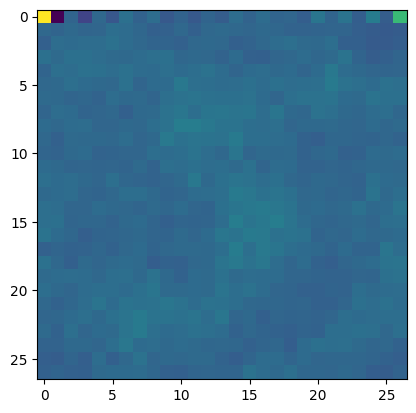

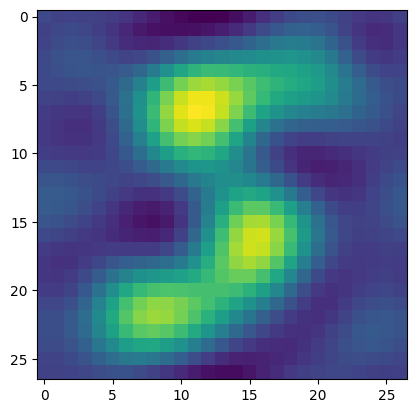

In [14]:
lowres, pred_img, gt = model.get_lowres_pred_gt(fc, mag_min, mag_max)

/tmp/ipykernel_48234/22062025.py:4: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig = plt.figure(figsize=(31/2., 10/2.))


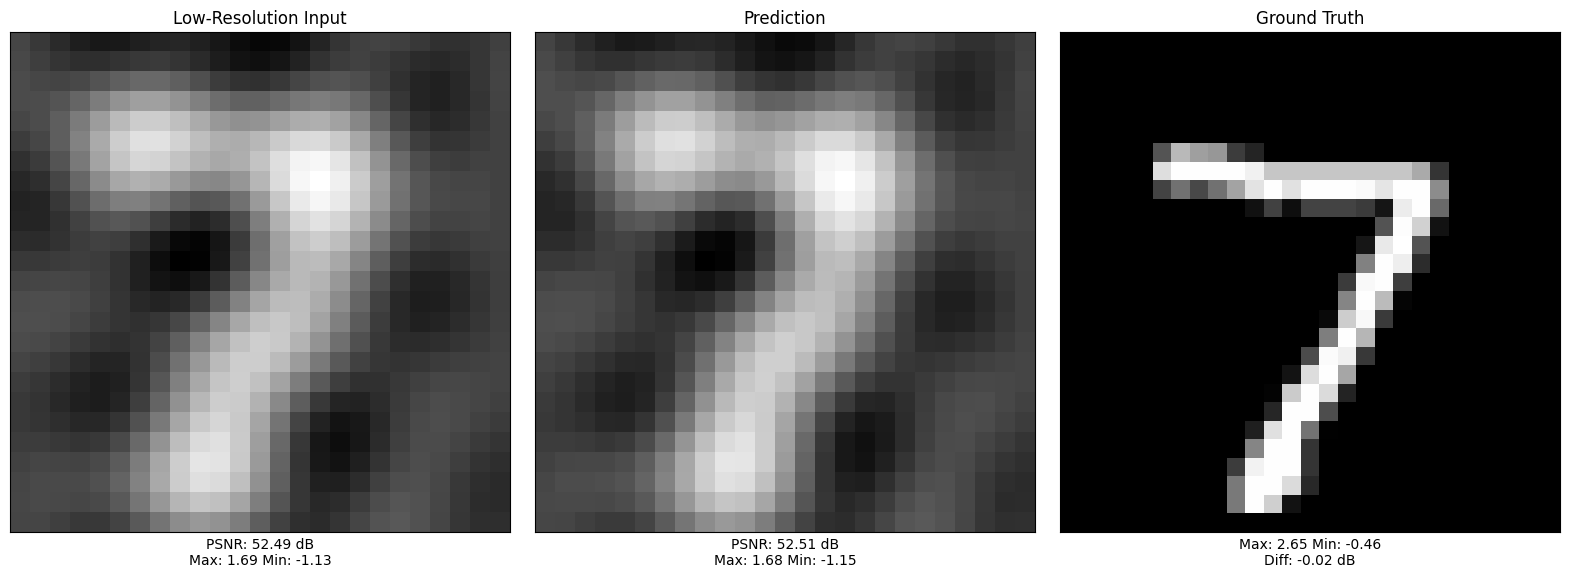

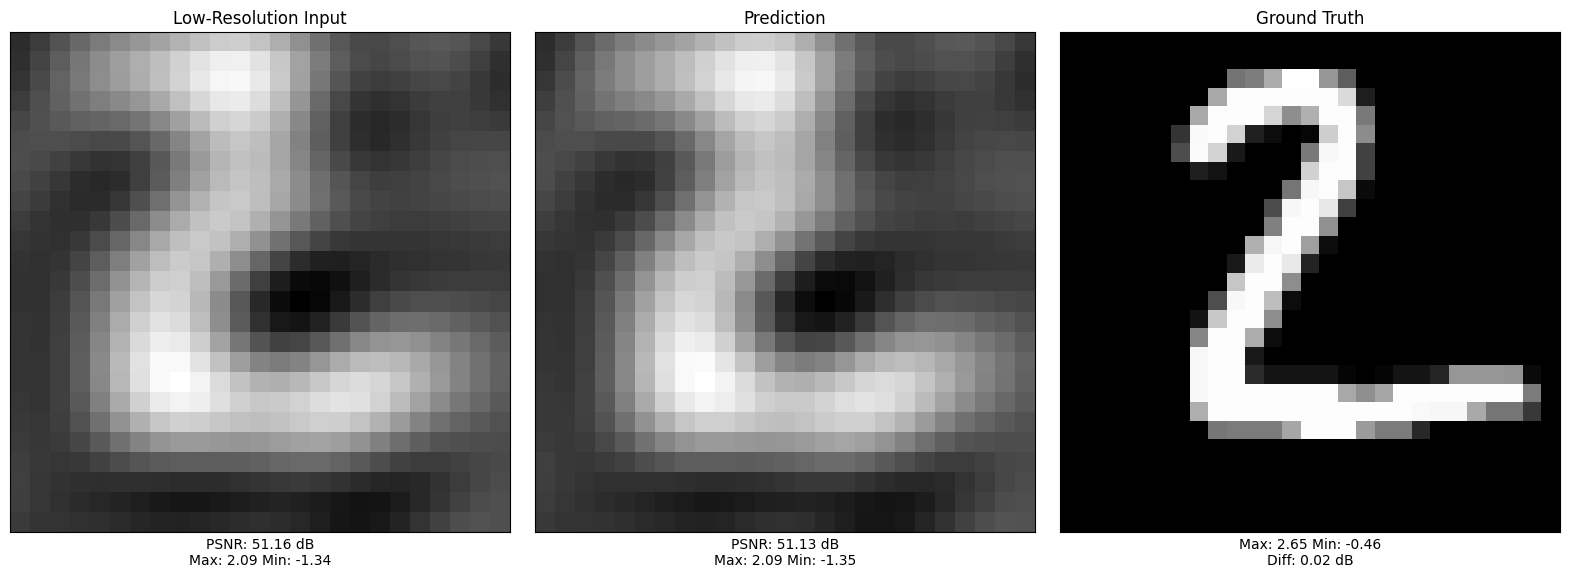

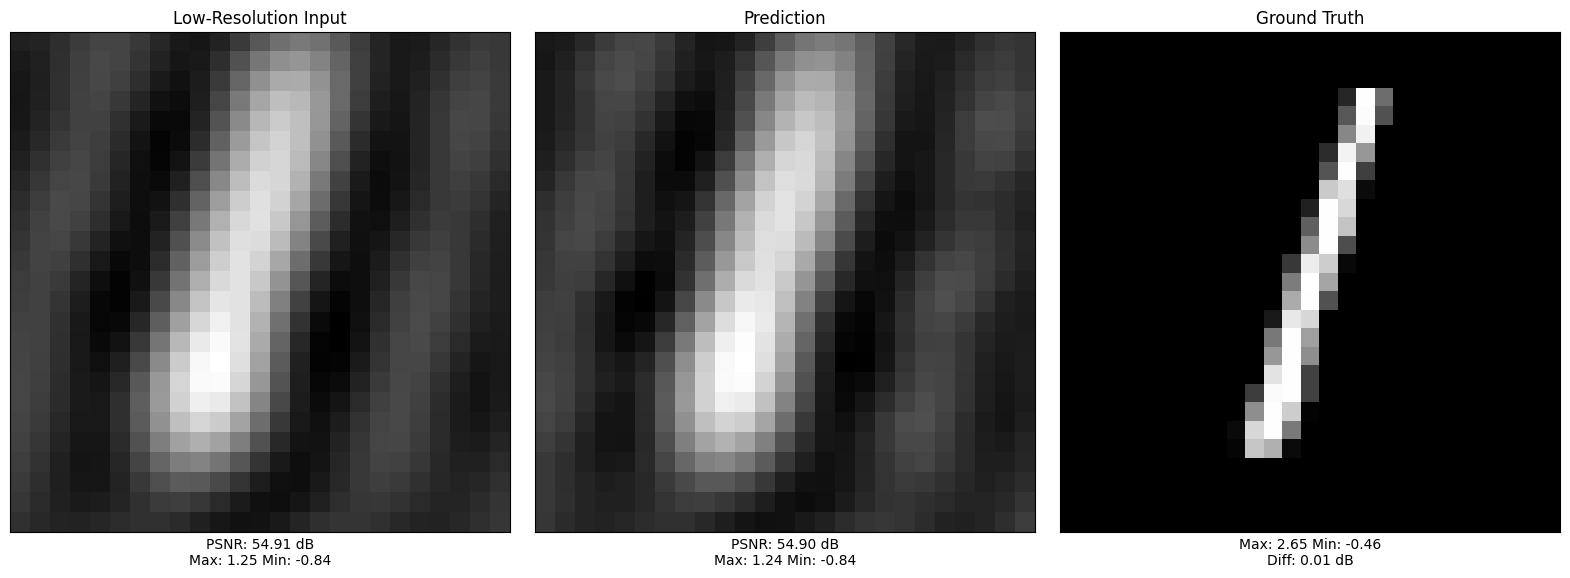

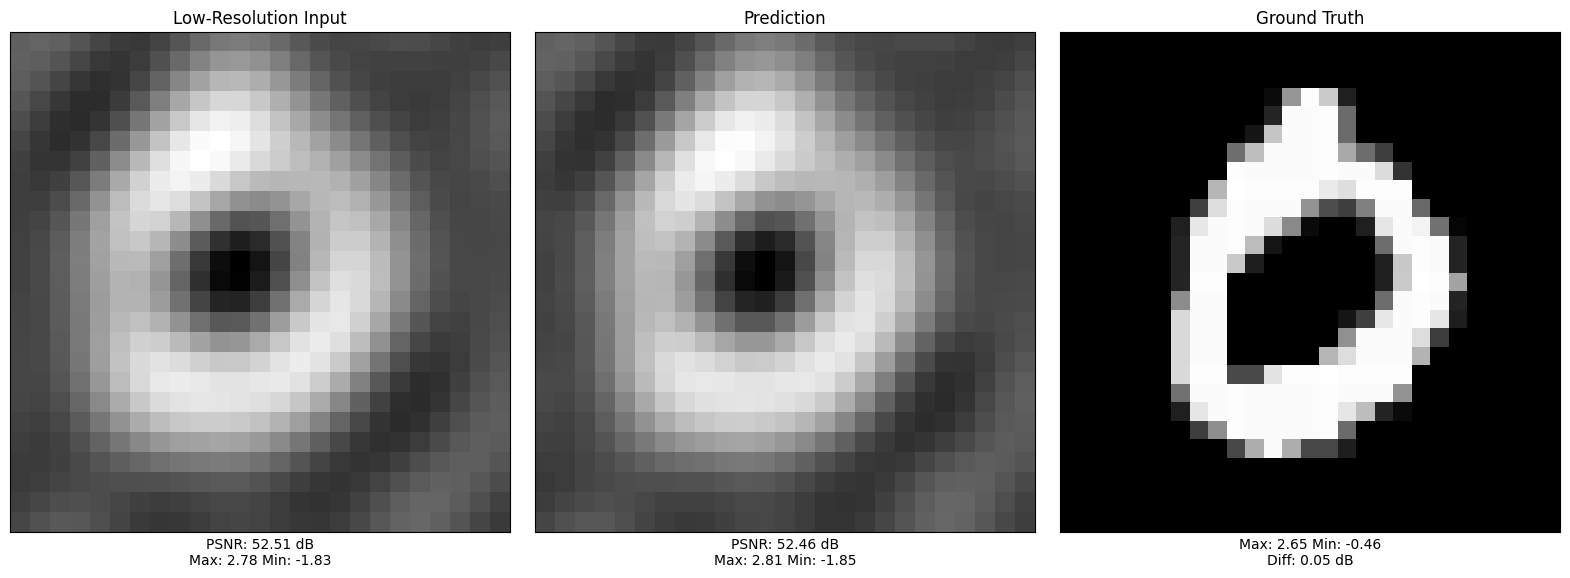

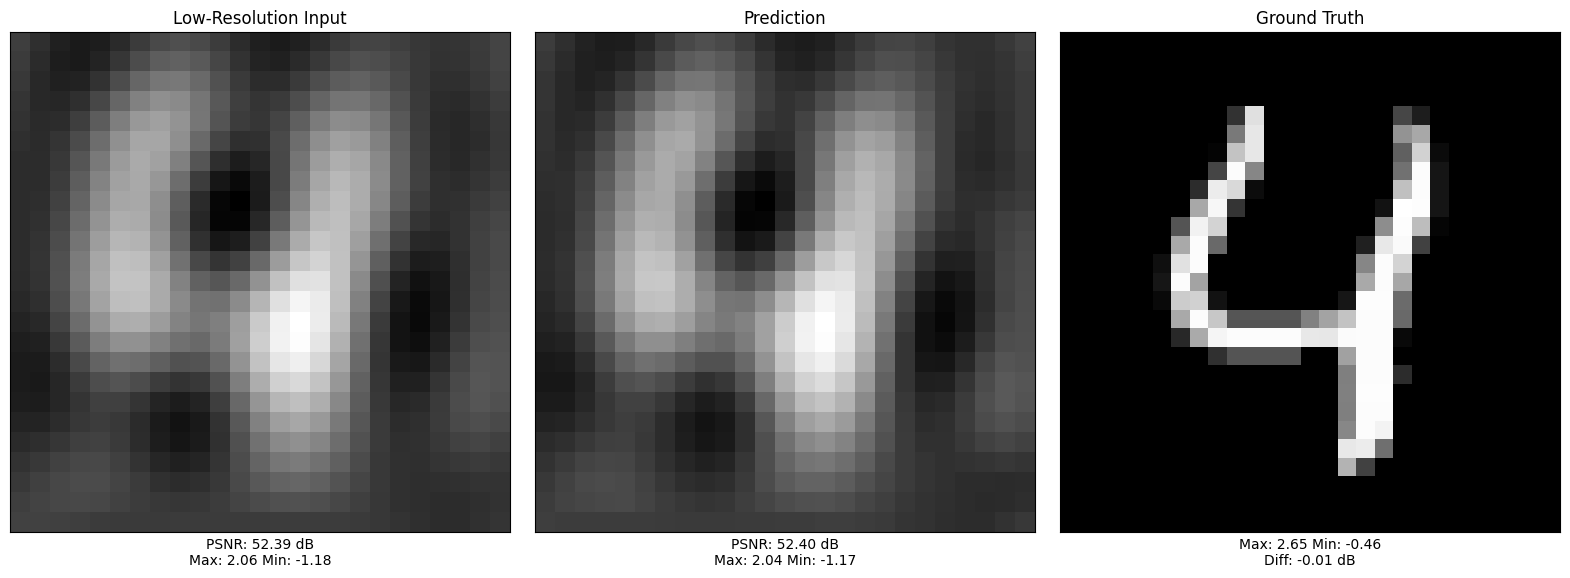

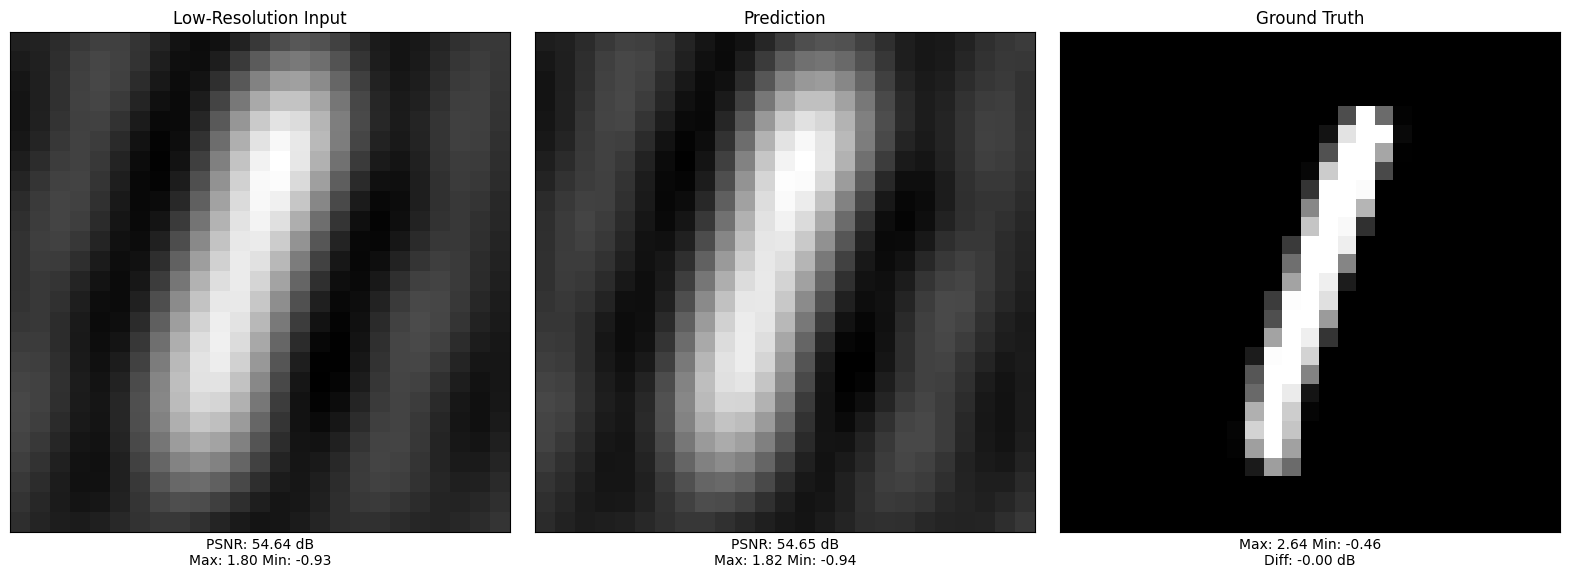

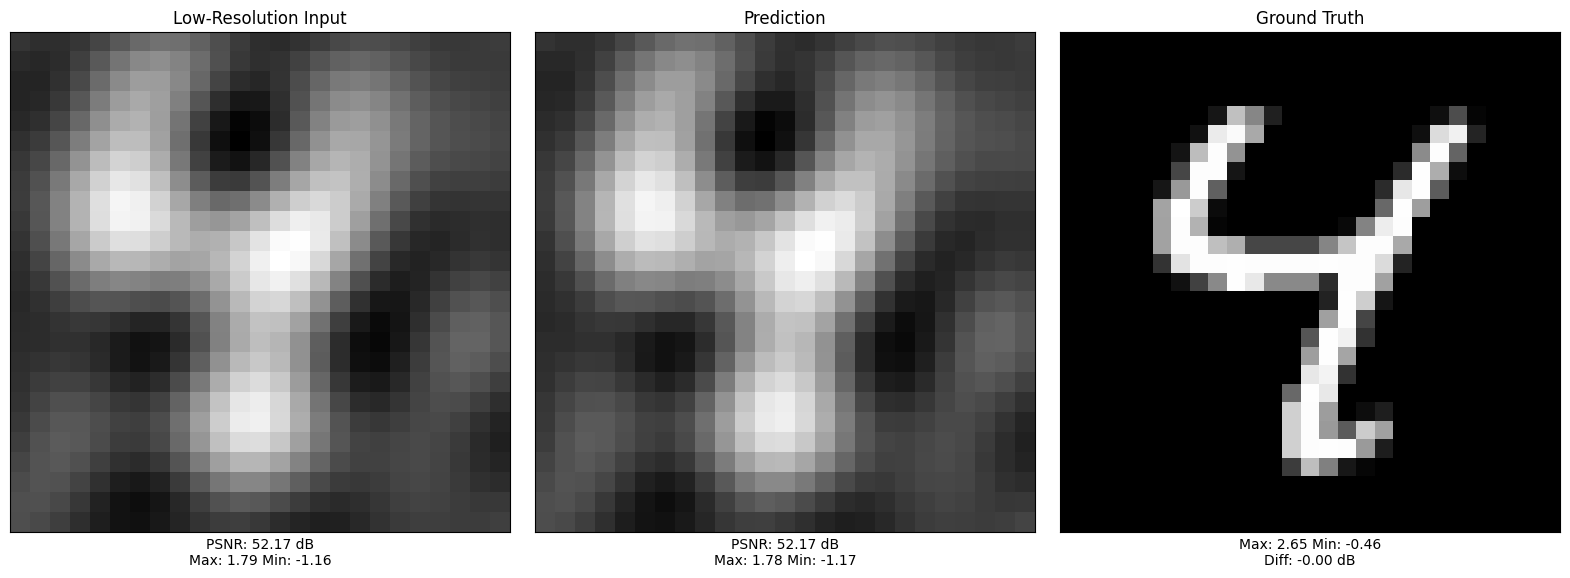

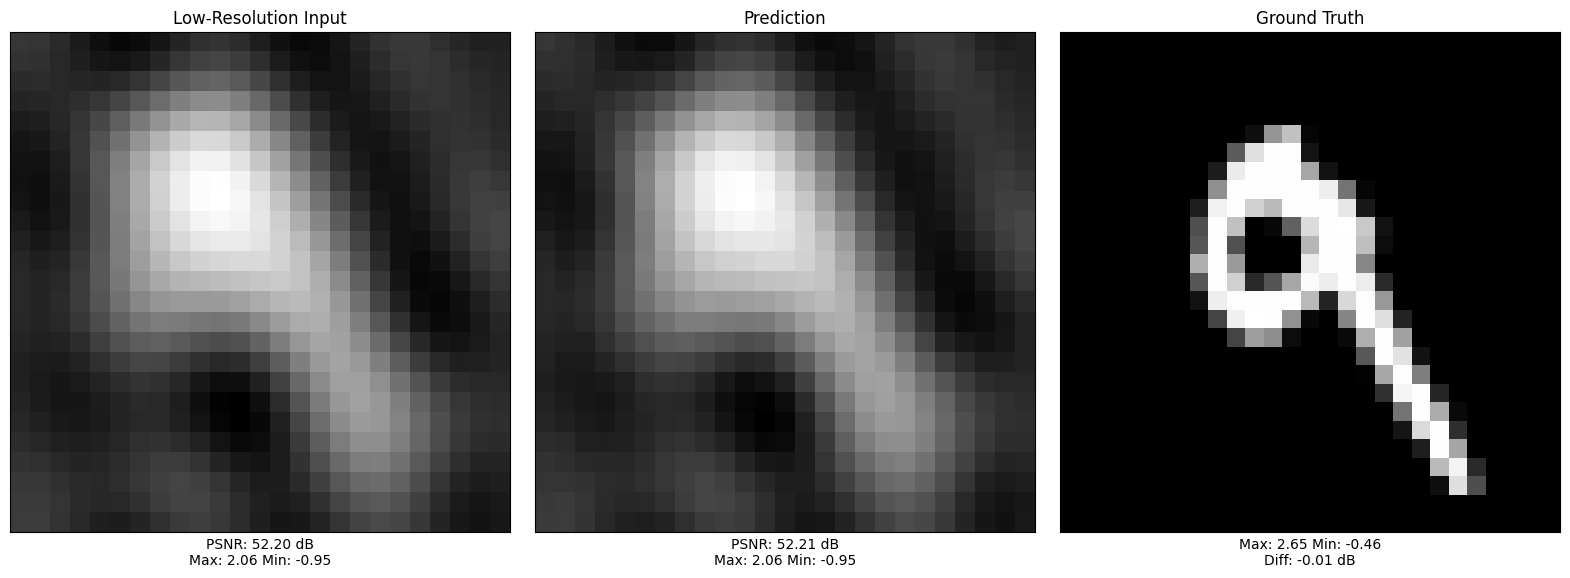

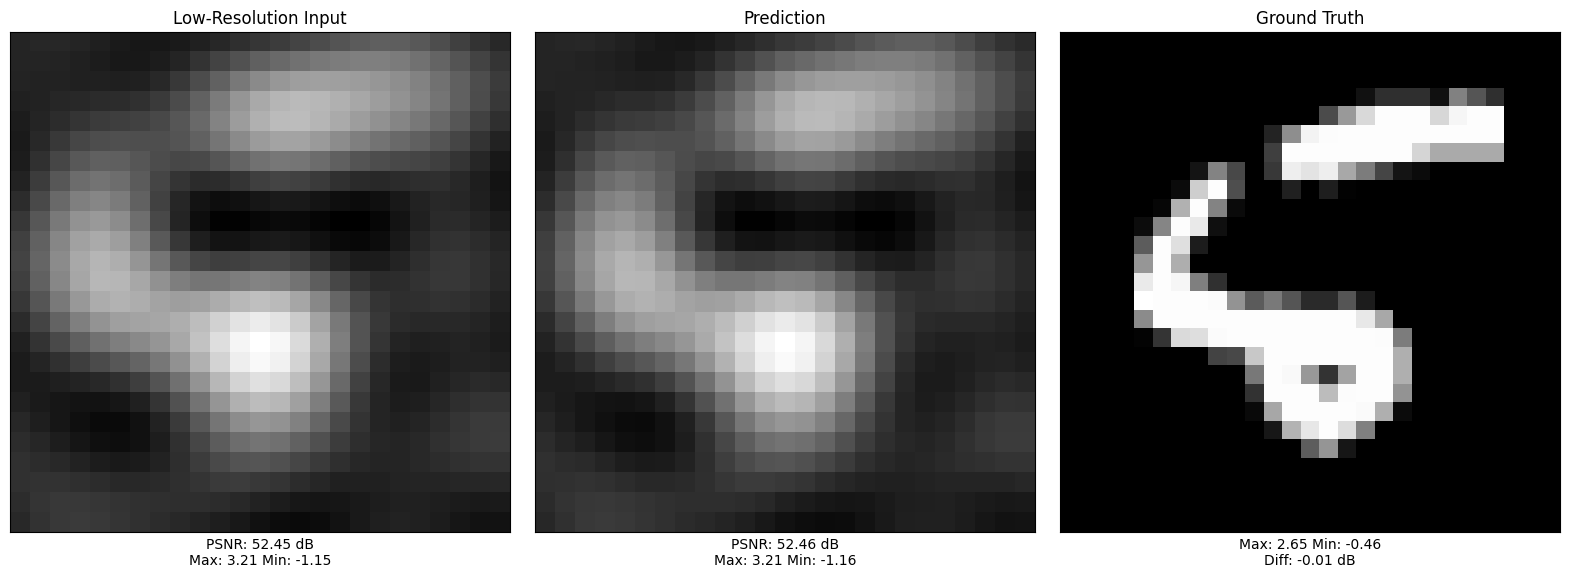

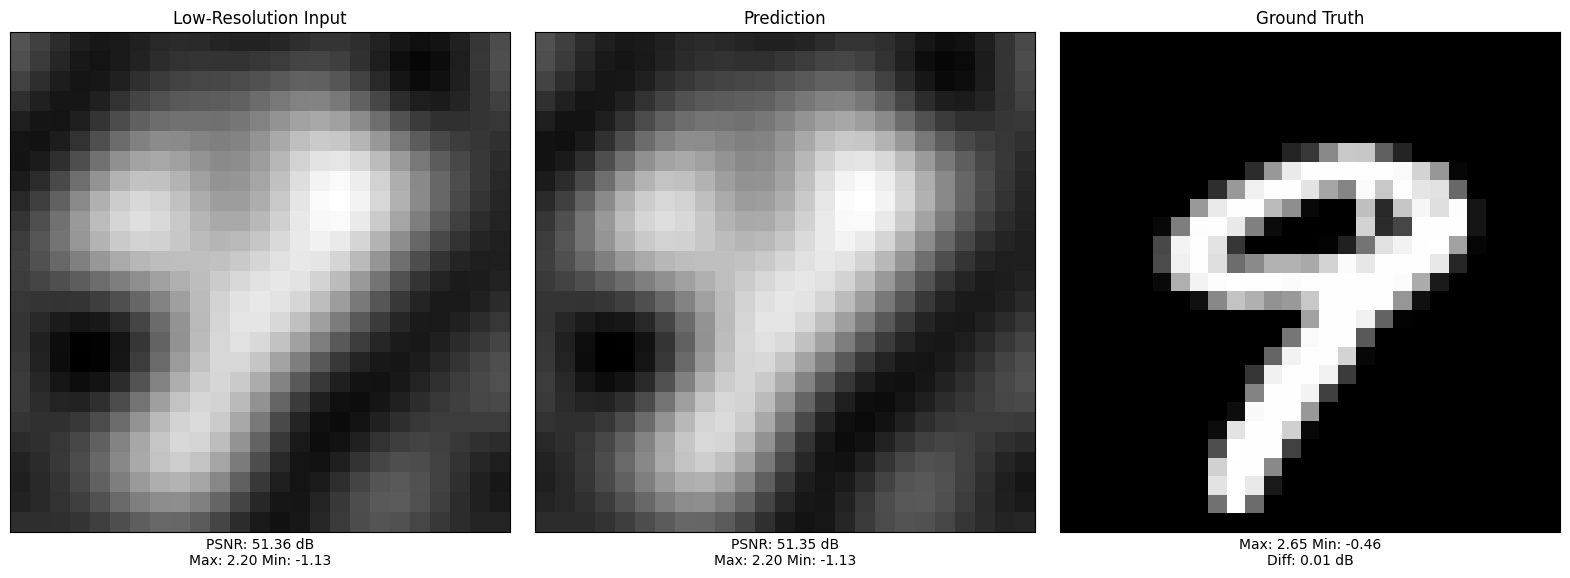

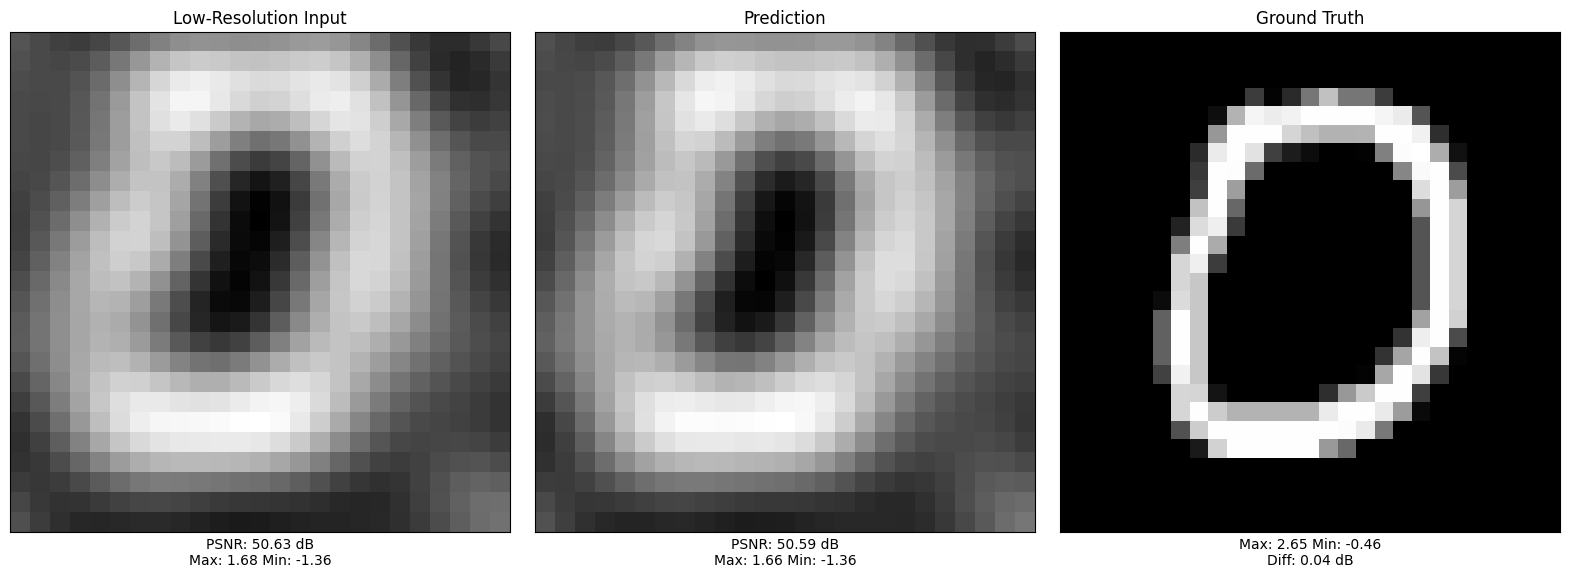

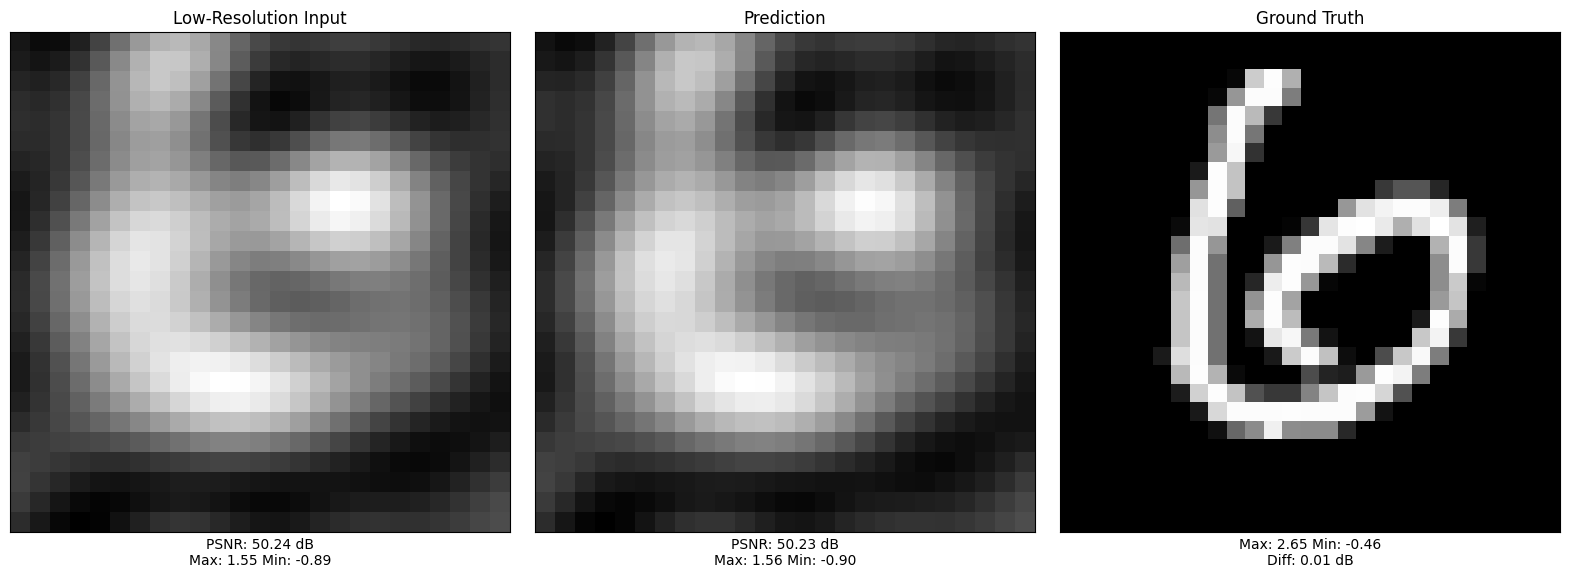

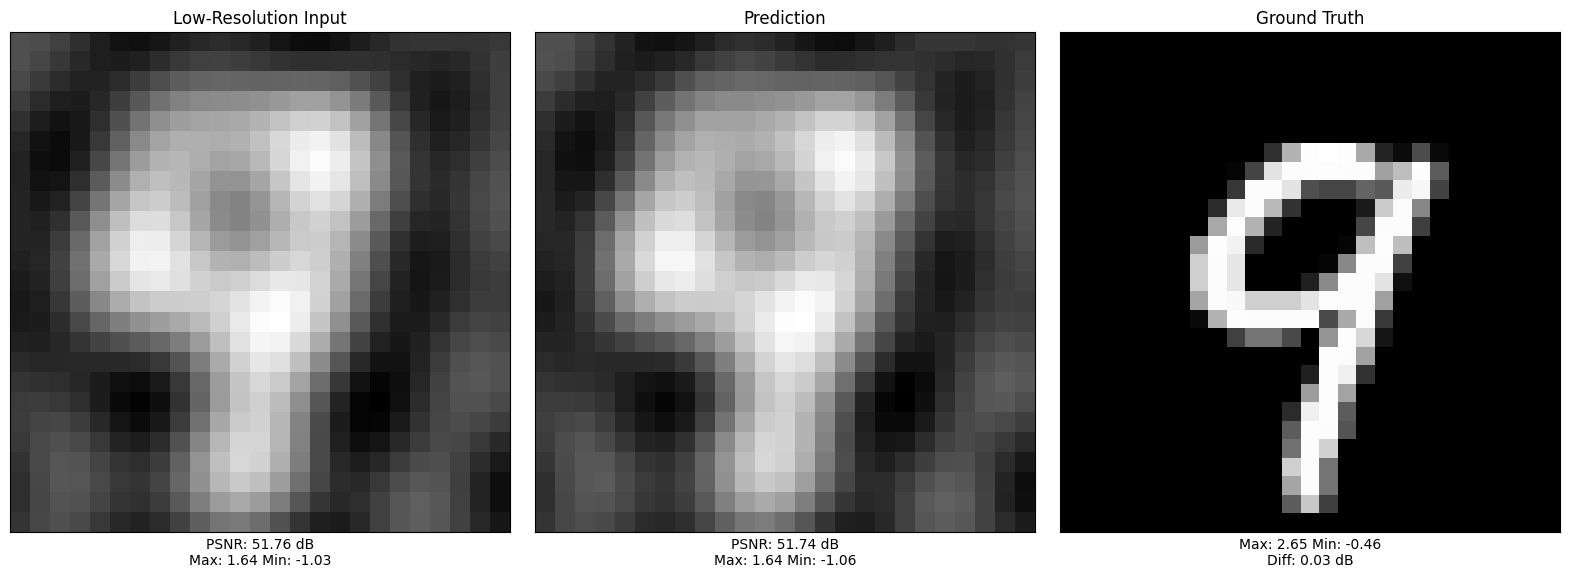

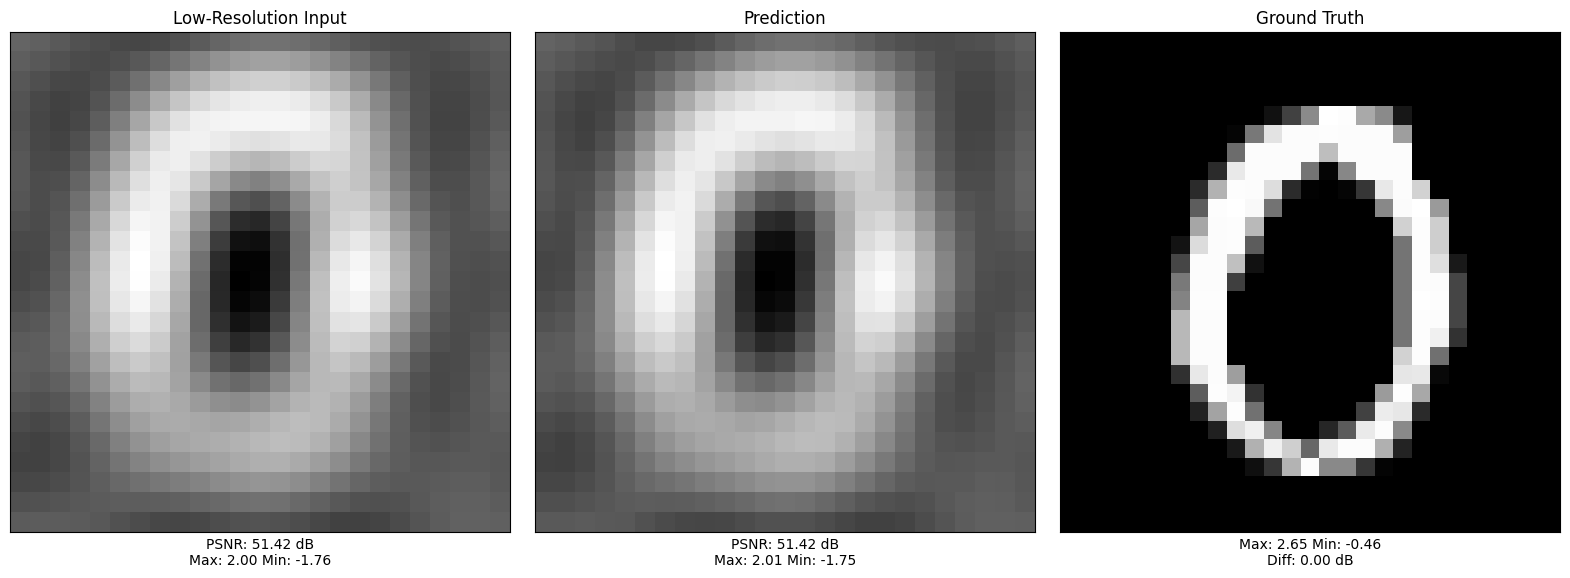

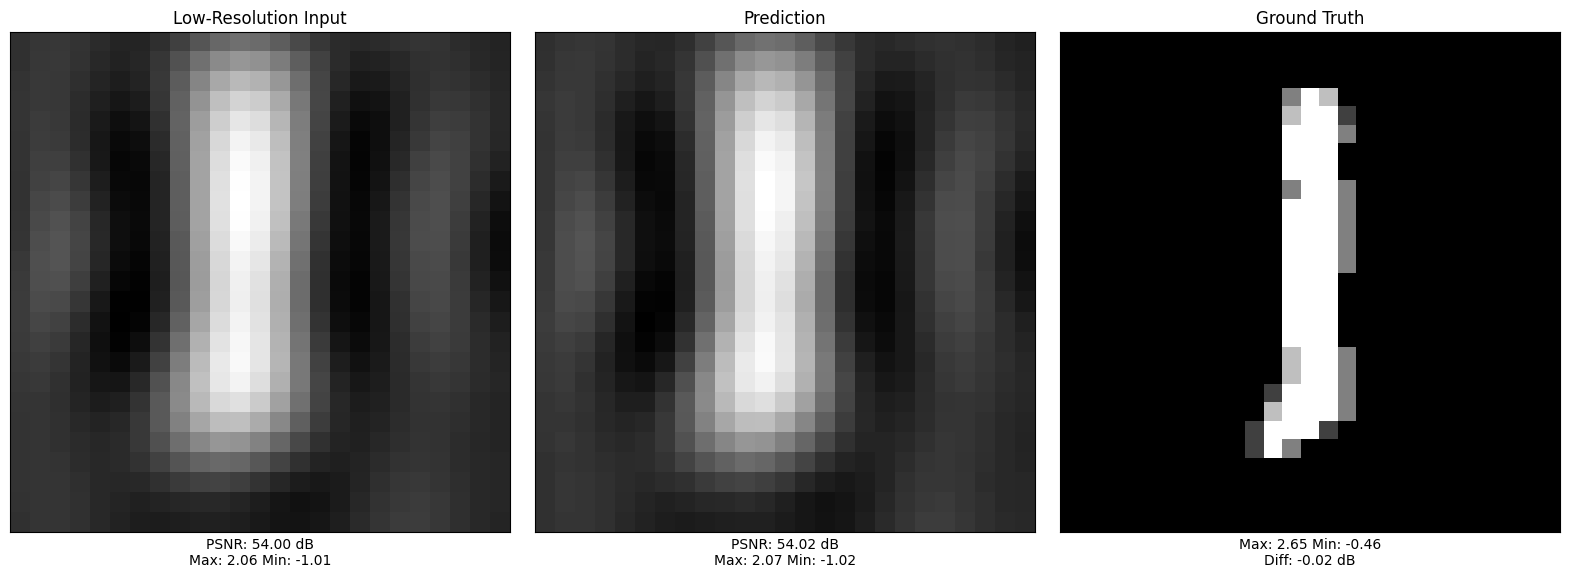

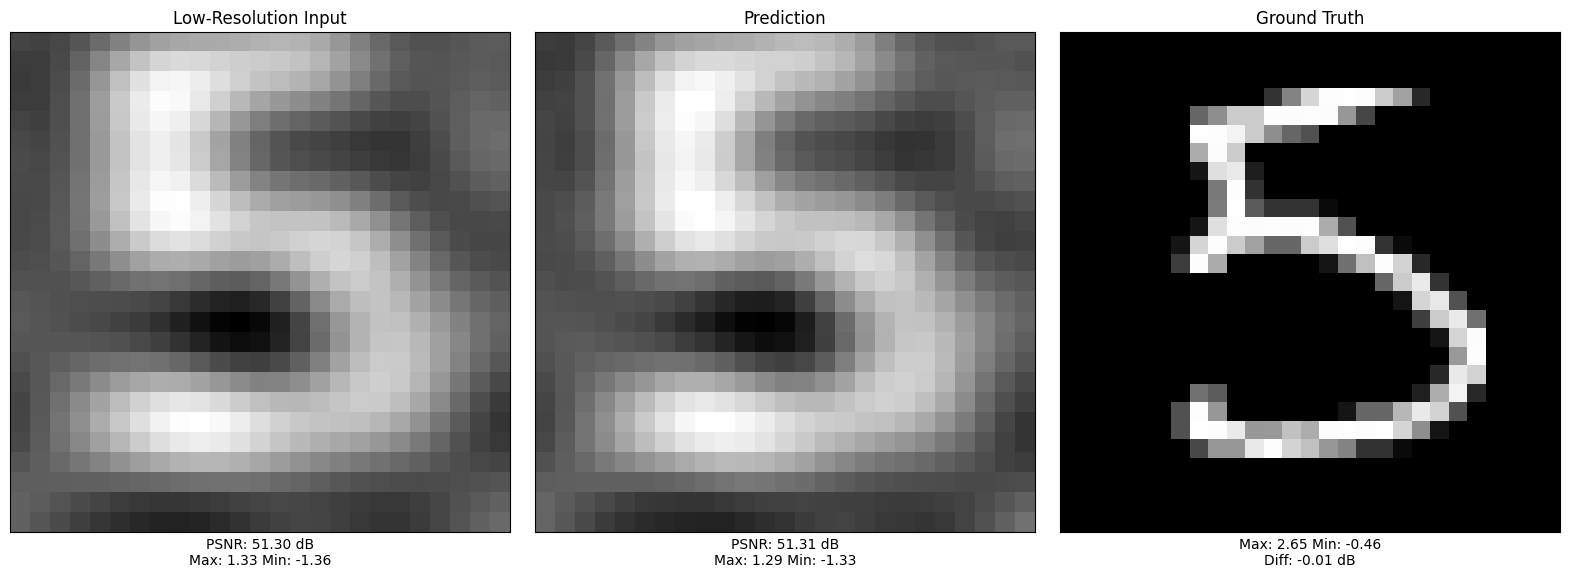

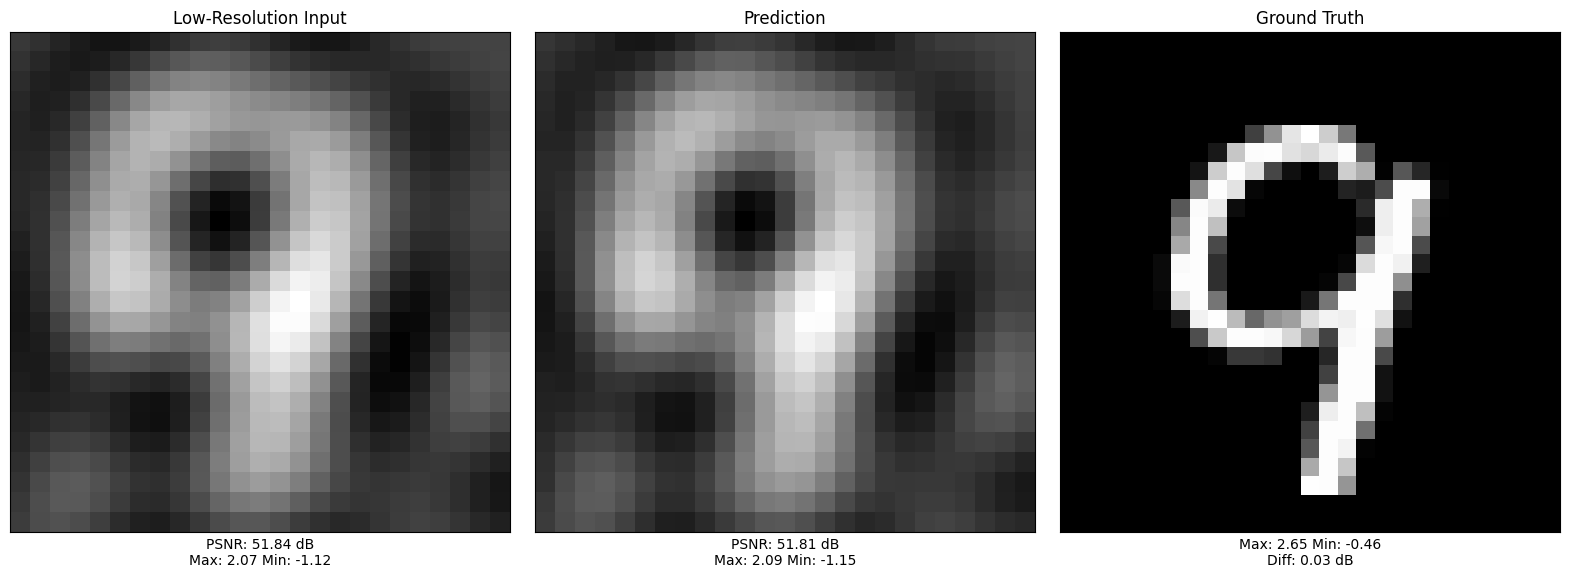

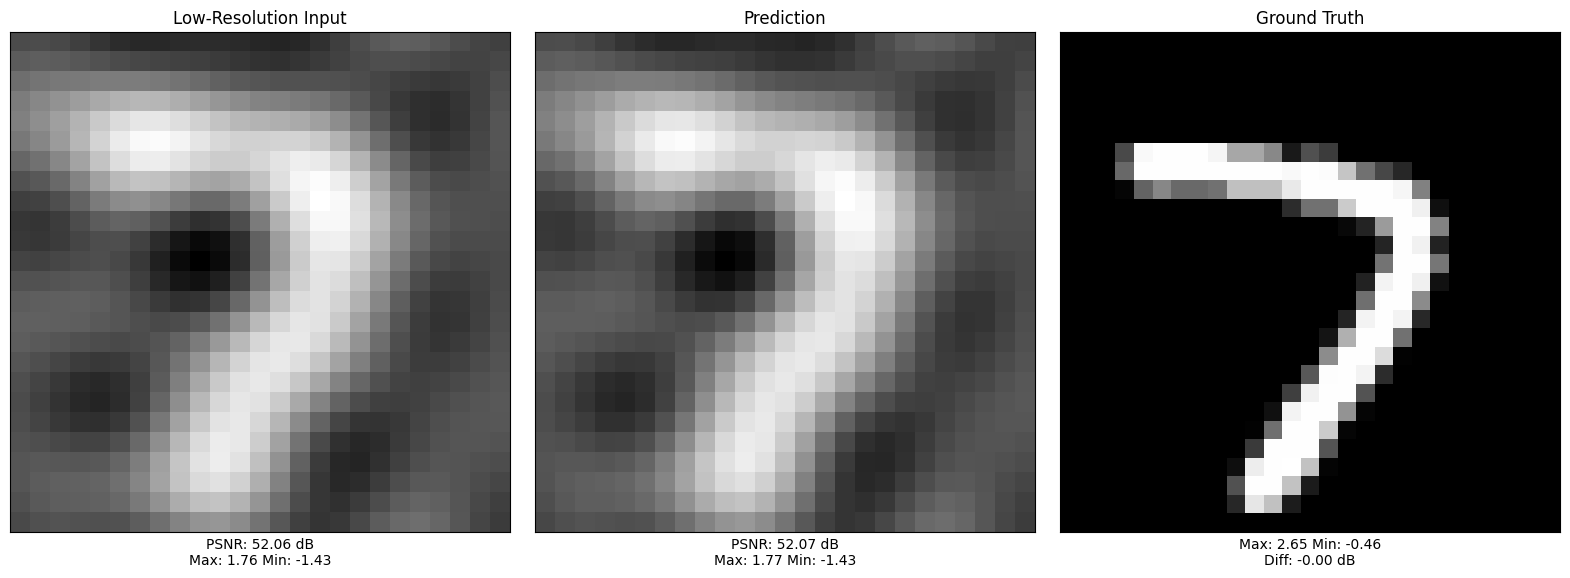

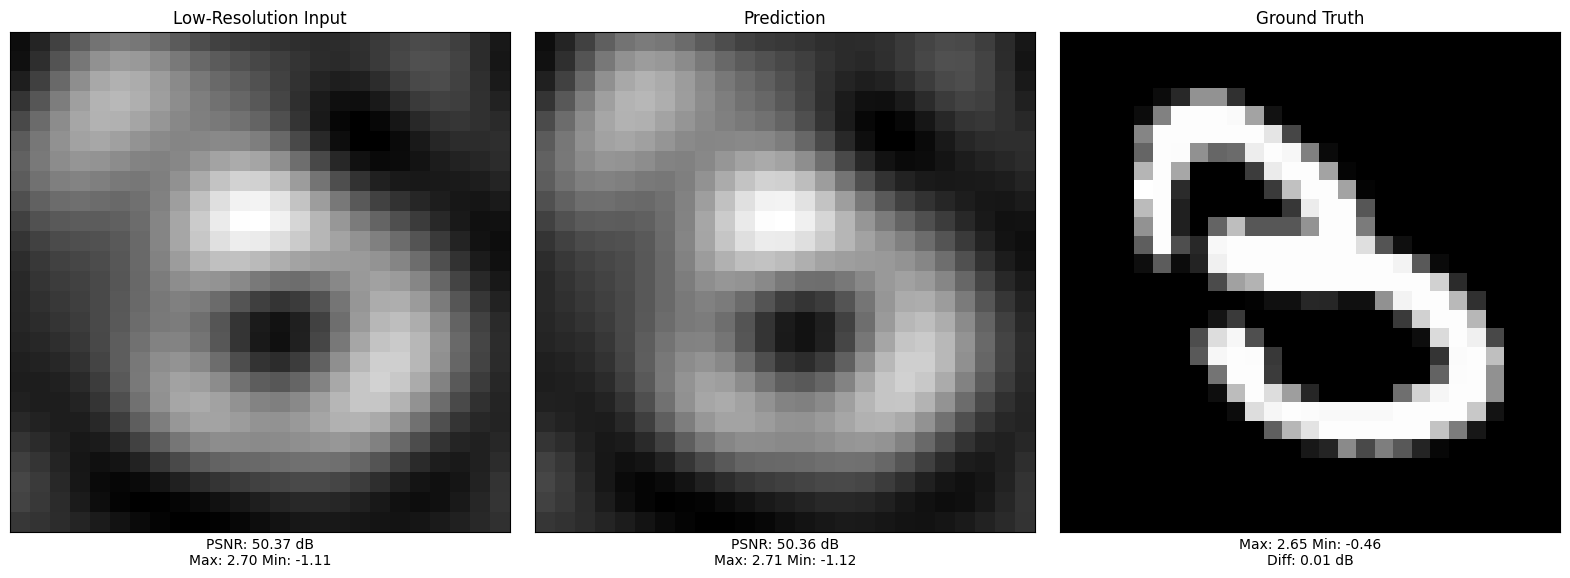

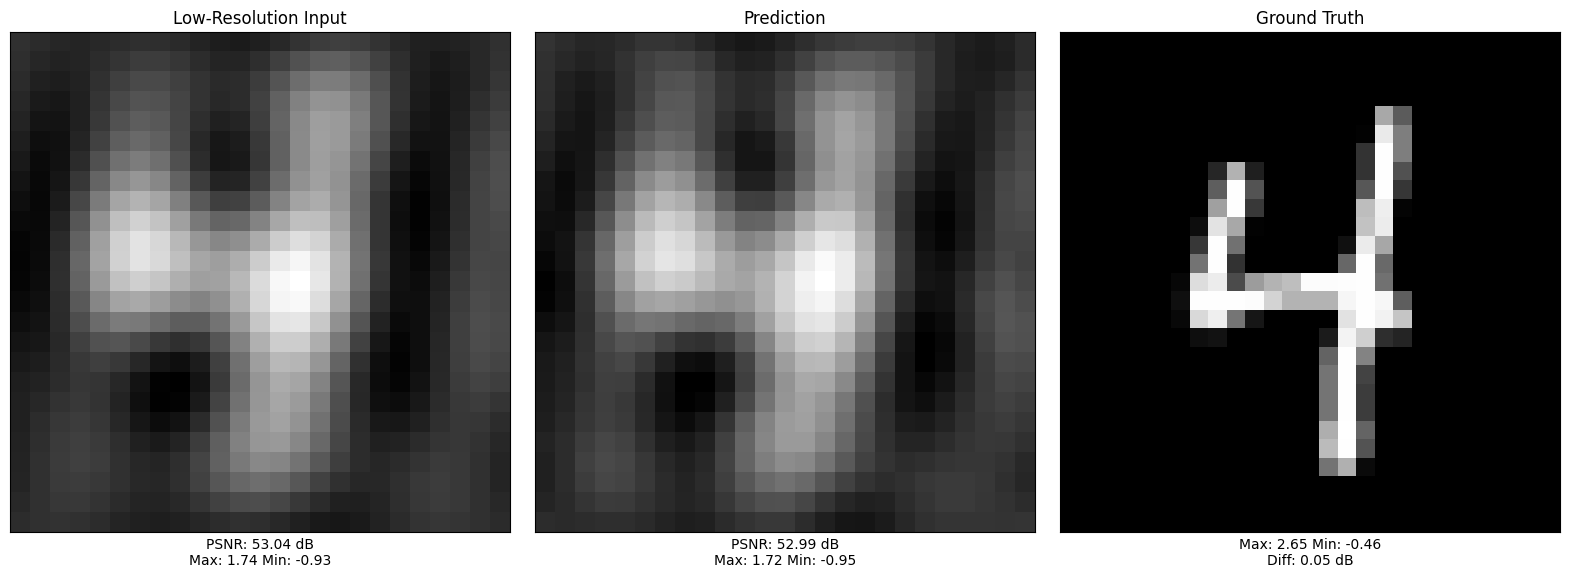

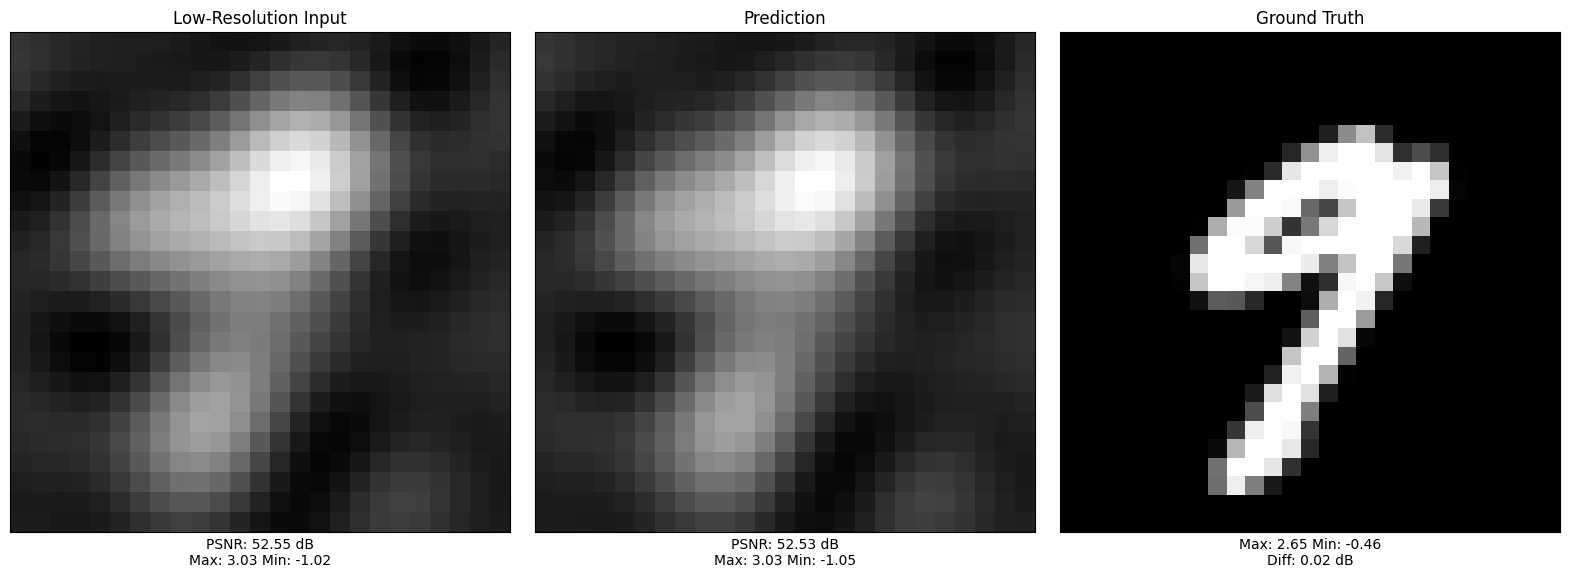

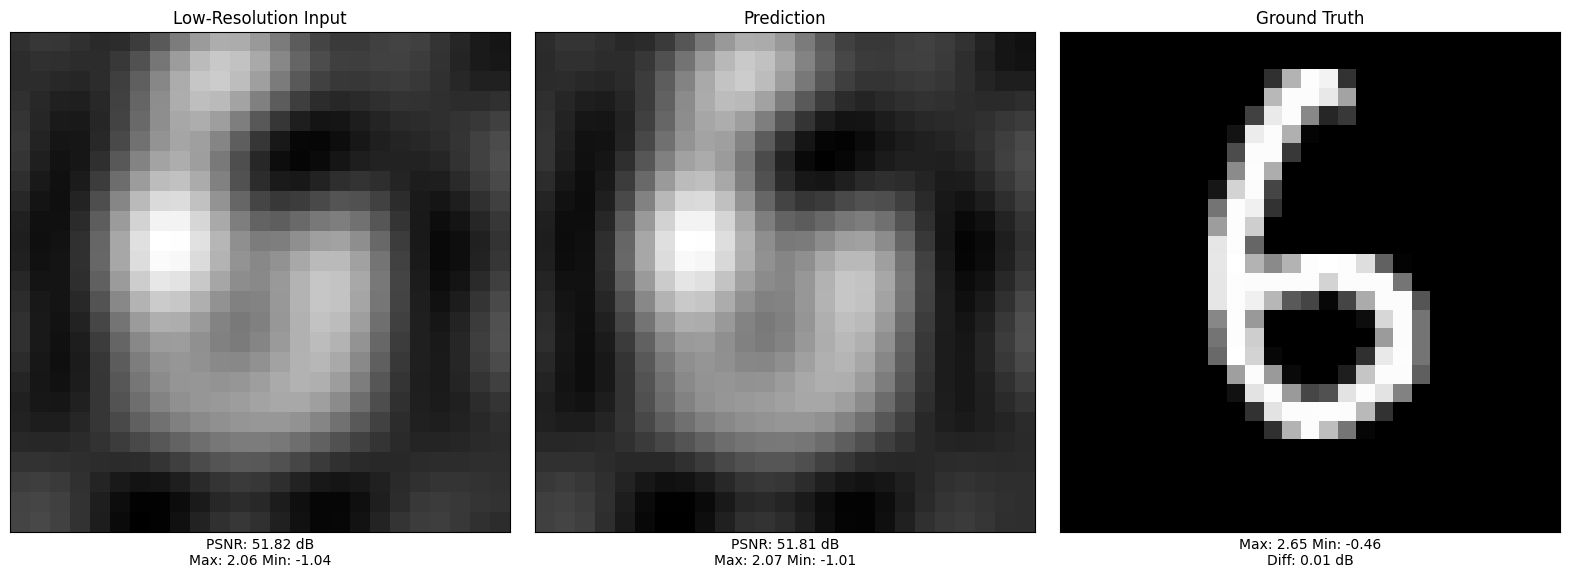

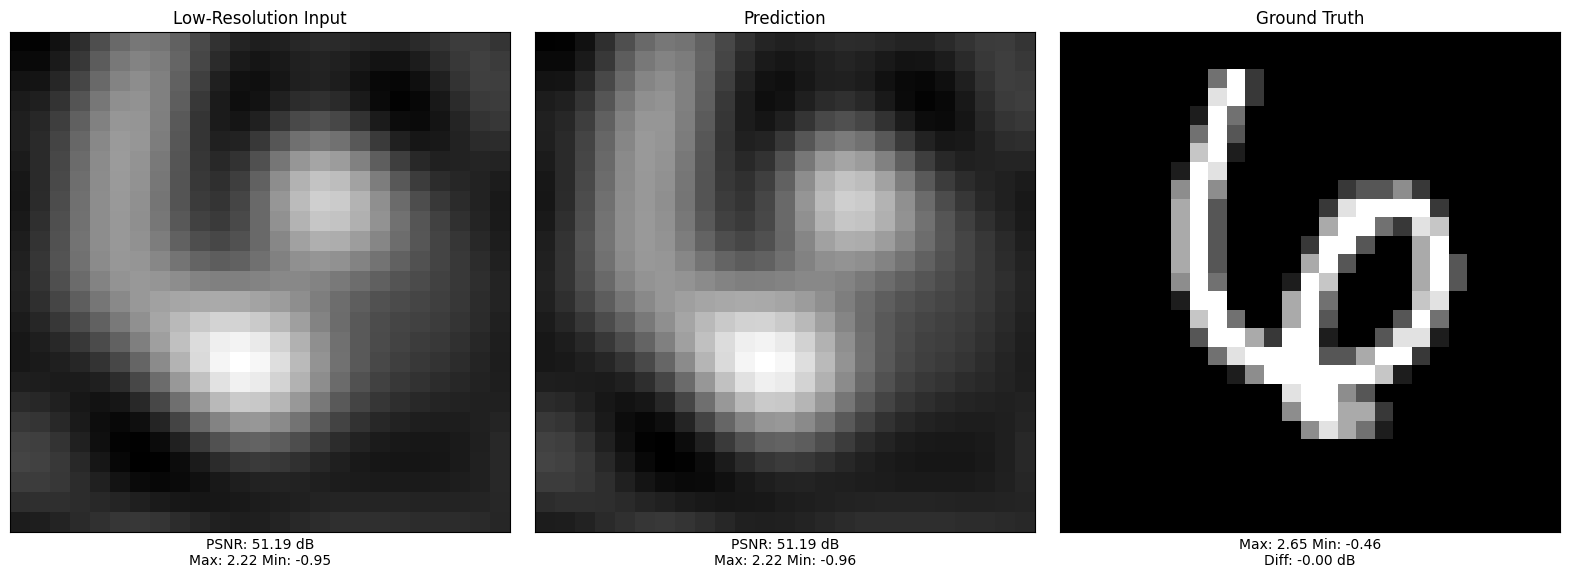

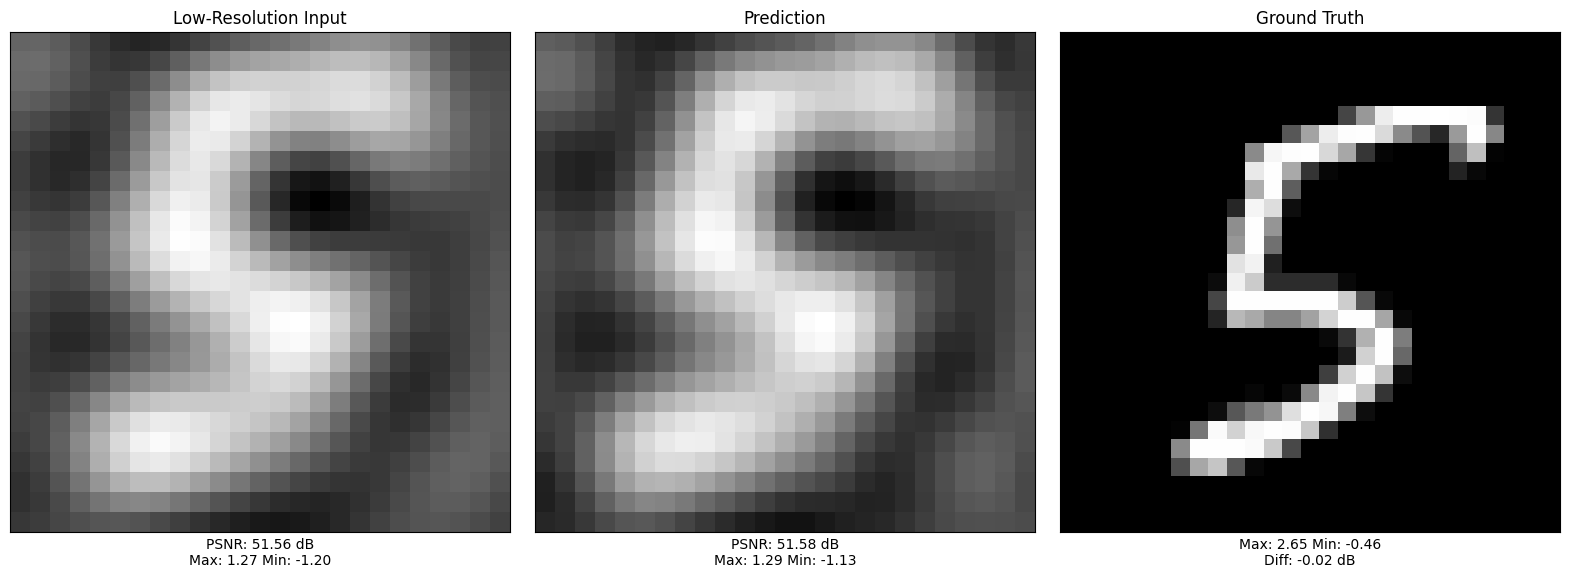

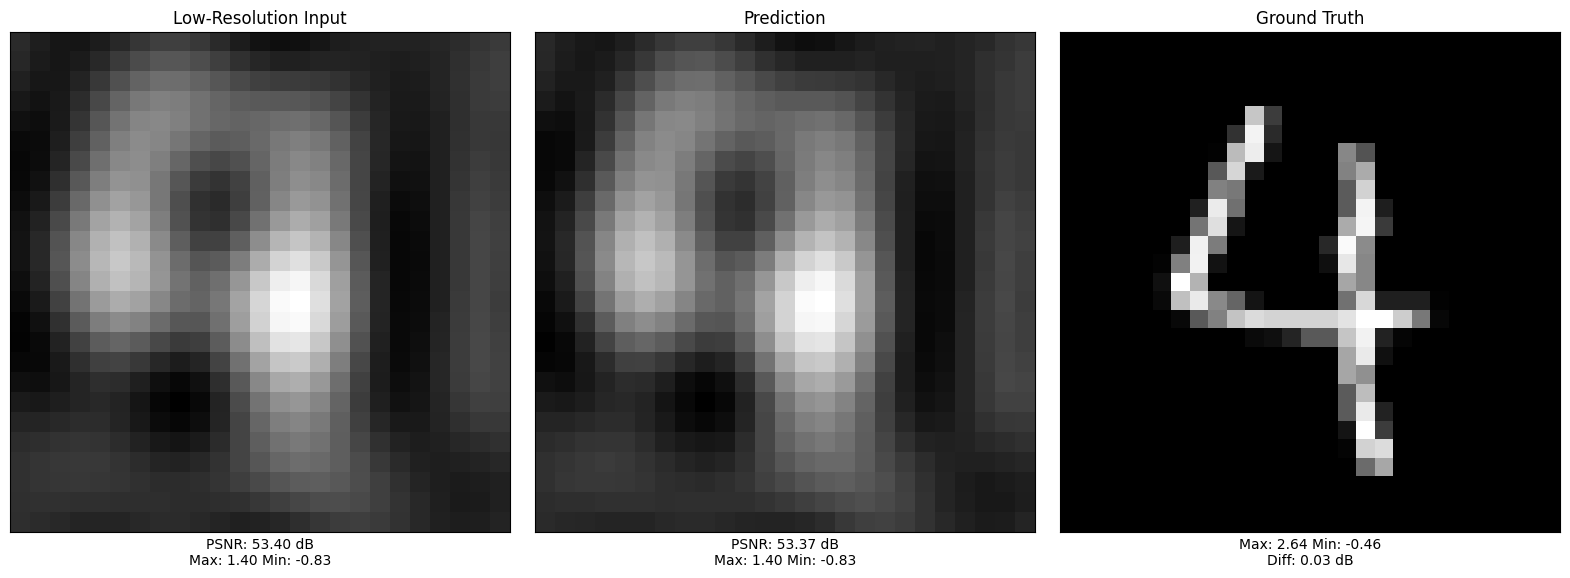

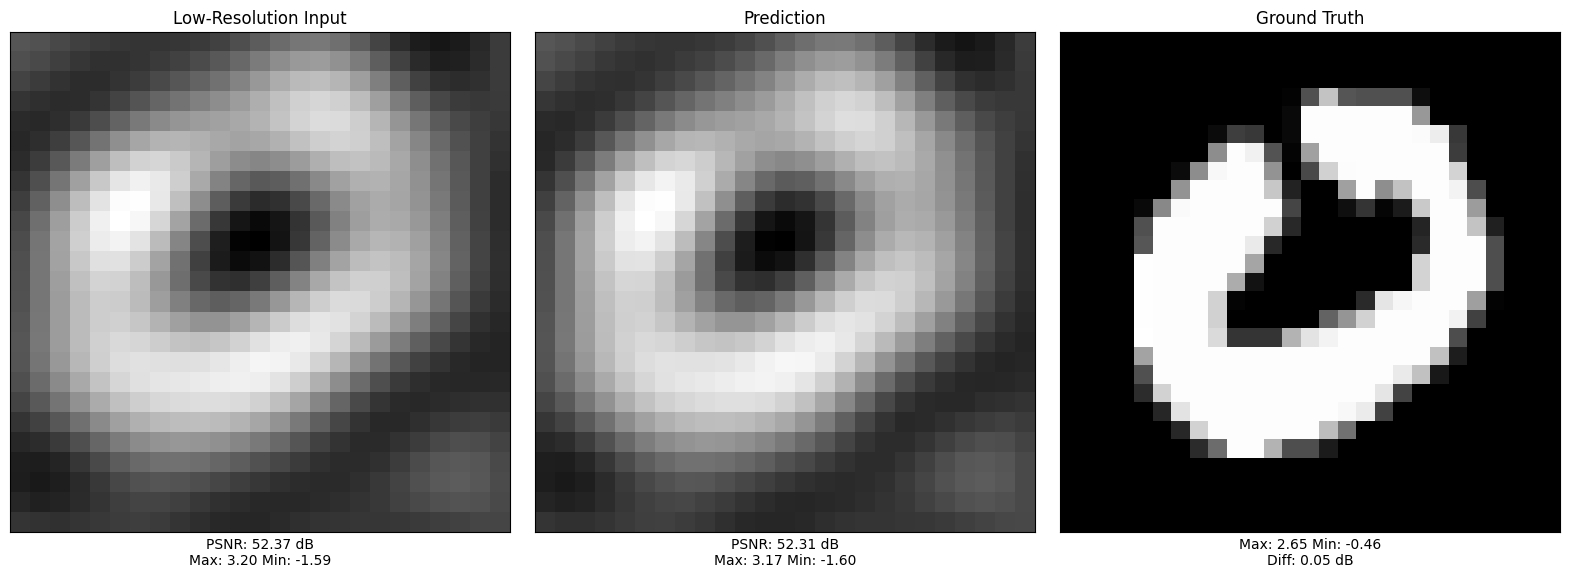

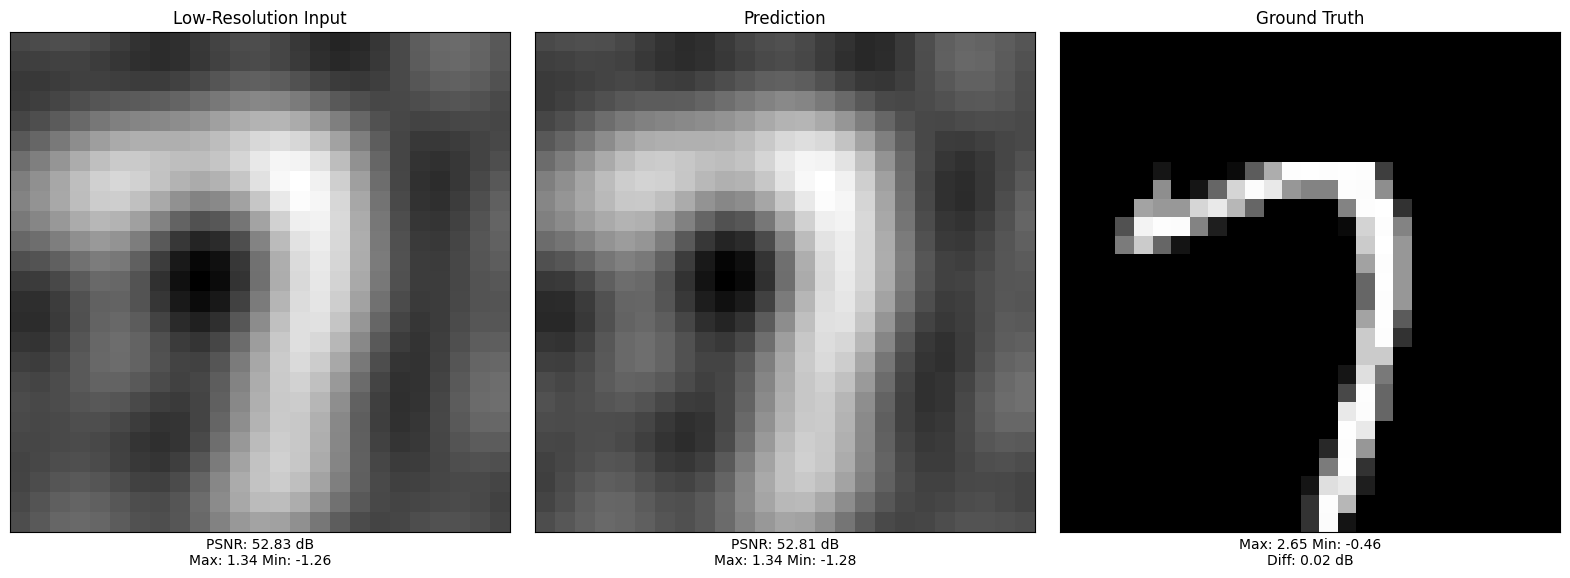

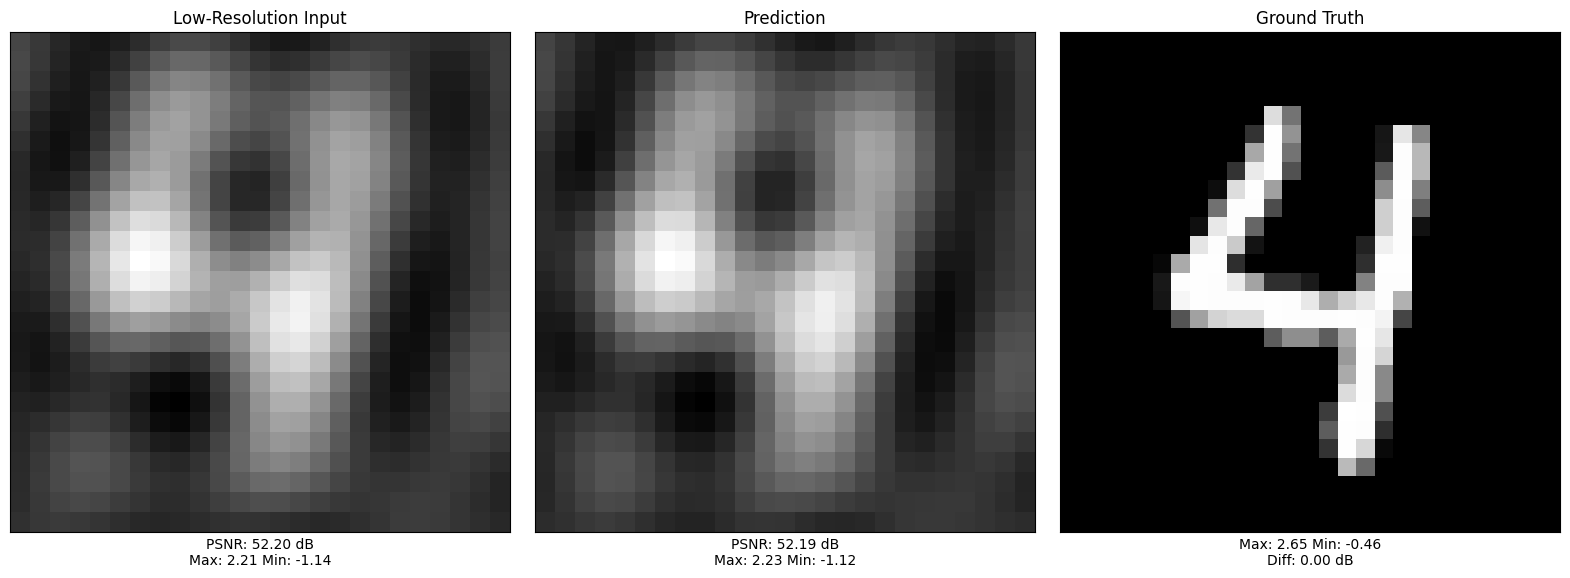

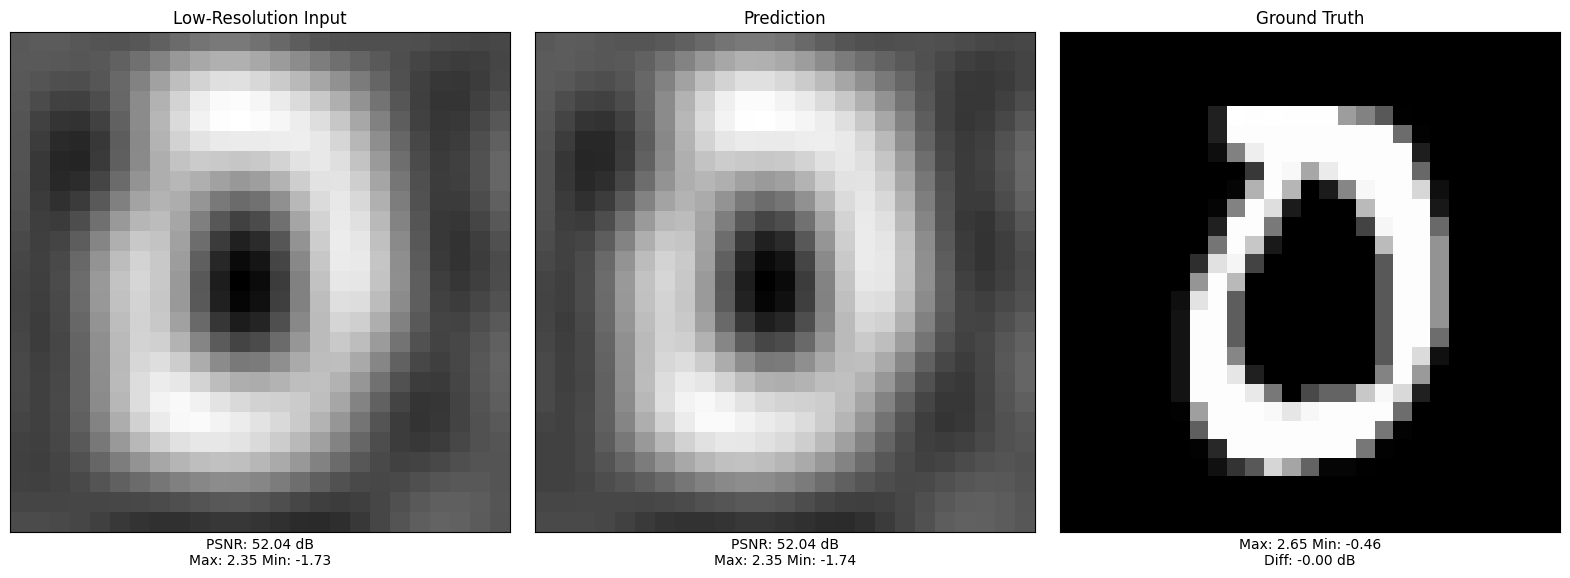

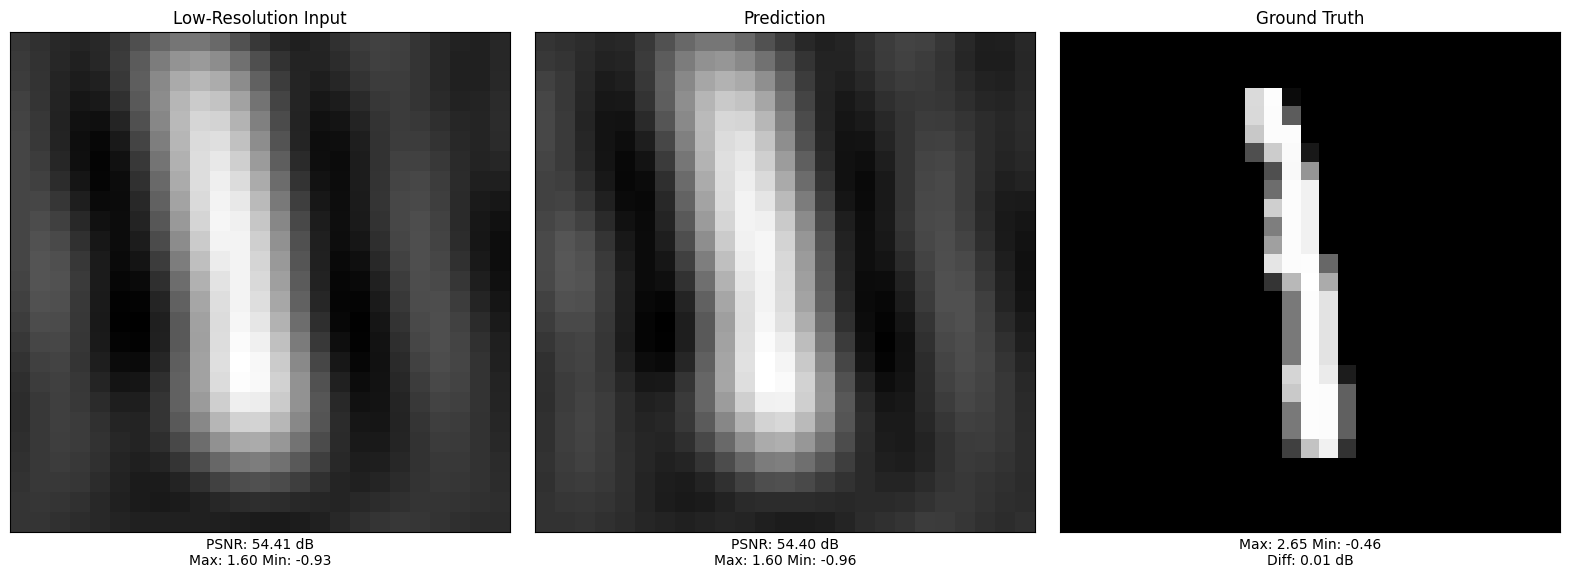

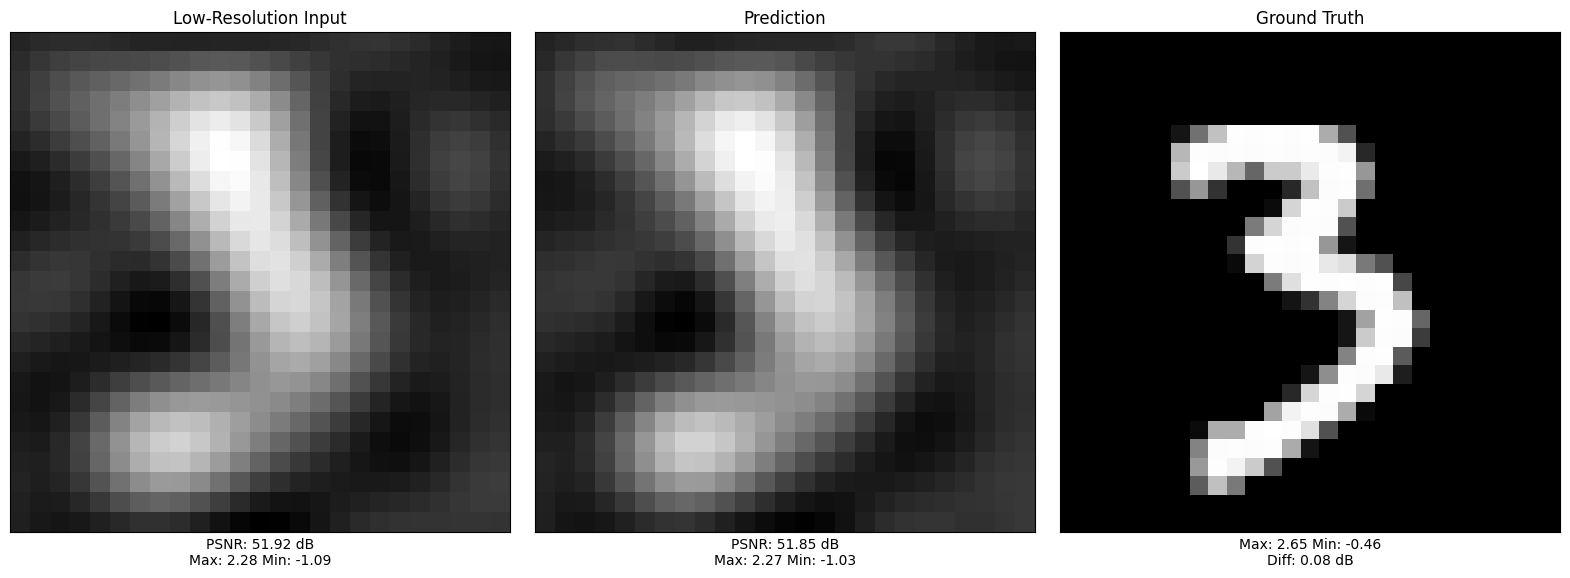

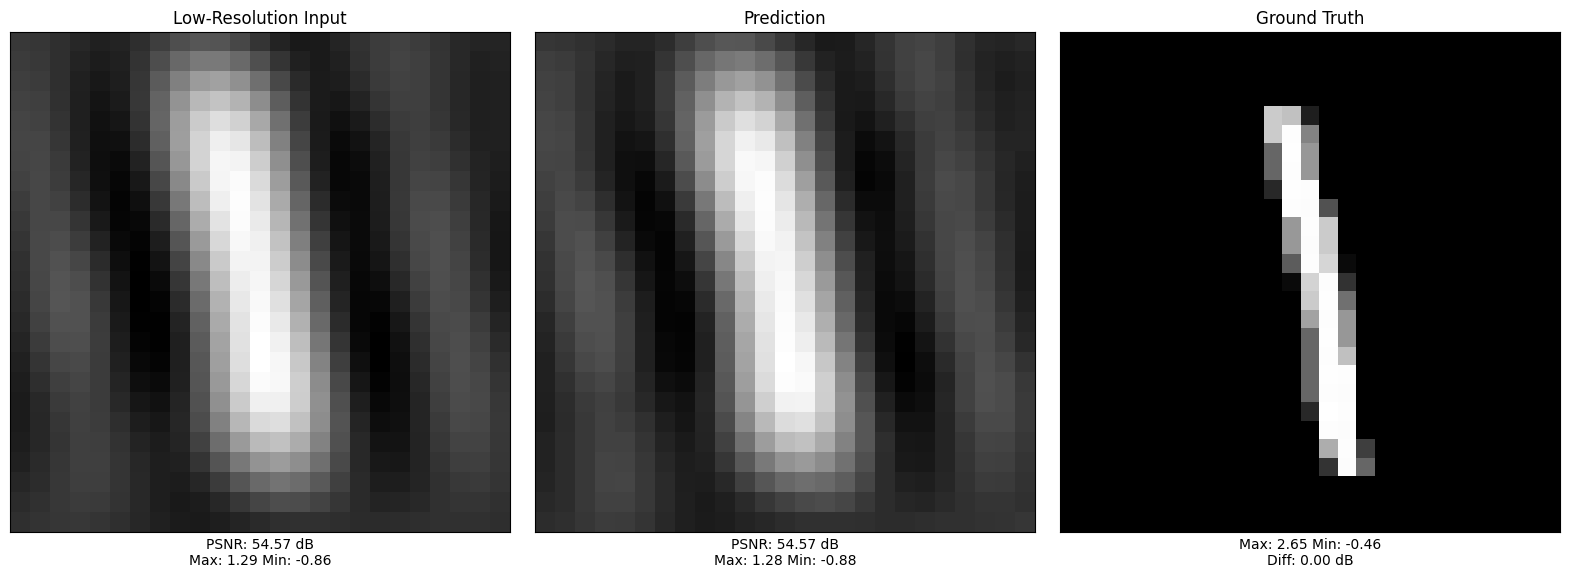

In [29]:
diff = []
for i in range(32):
    sample = i
    fig = plt.figure(figsize=(31/2., 10/2.)) 
    gs = gridspec.GridSpec(1, 5, width_ratios=[10,0.5, 10, 0.5, 10]) 
    ax0 = plt.subplot(gs[0])
    ax1 = plt.subplot(gs[2])
    ax2 = plt.subplot(gs[4])
    plt.subplots_adjust(top = 1, bottom = 0, right = 1, left = 0, 
                        hspace = 0, wspace = 0)

    ax0.xaxis.set_major_locator(plt.NullLocator())
    ax0.yaxis.set_major_locator(plt.NullLocator())
    lowres_vs_gt_psnr = PSNR(gt[sample][2:, 2:], lowres[sample][2:, 2:], drange=torch.tensor(255., dtype=torch.float32))
    ax0.imshow(lowres[sample][2:, 2:], cmap='gray')
    ax0.set_title('Low-Resolution Input');
    ax0.set_xlabel(f'PSNR: {lowres_vs_gt_psnr:.2f} dB\nMax: {lowres[sample].max():.2f} Min: {lowres[sample].min():.2f}');
    ax0.axis('equal');

    ax1.xaxis.set_major_locator(plt.NullLocator())
    ax1.yaxis.set_major_locator(plt.NullLocator())
    
    ax1.imshow(pred_img[sample][2:, 2:], cmap='gray')
    pred_vs_gt_psnr = PSNR(gt[sample][2:, 2:], pred_img[sample][2:, 2:], drange=torch.tensor(255., dtype=torch.float32))
    ax1.set_title('Prediction');
    ax1.set_xlabel(f'PSNR: {pred_vs_gt_psnr:.2f} dB\nMax: {pred_img[sample].max():.2f} Min: {pred_img[sample].min():.2f}');
    ax1.axis('equal');


    ax2.xaxis.set_major_locator(plt.NullLocator())
    ax2.yaxis.set_major_locator(plt.NullLocator())
    ax2.imshow(gt[sample], cmap='gray')
    ax2.set_title('Ground Truth');
    ax2.set_xlabel(f'Max: {gt[sample].max():.2f} Min: {gt[sample].min():.2f}\nDiff: {lowres_vs_gt_psnr - pred_vs_gt_psnr:.2f} dB');
    ax2.axis('equal');
    diff.append(lowres_vs_gt_psnr - pred_vs_gt_psnr)


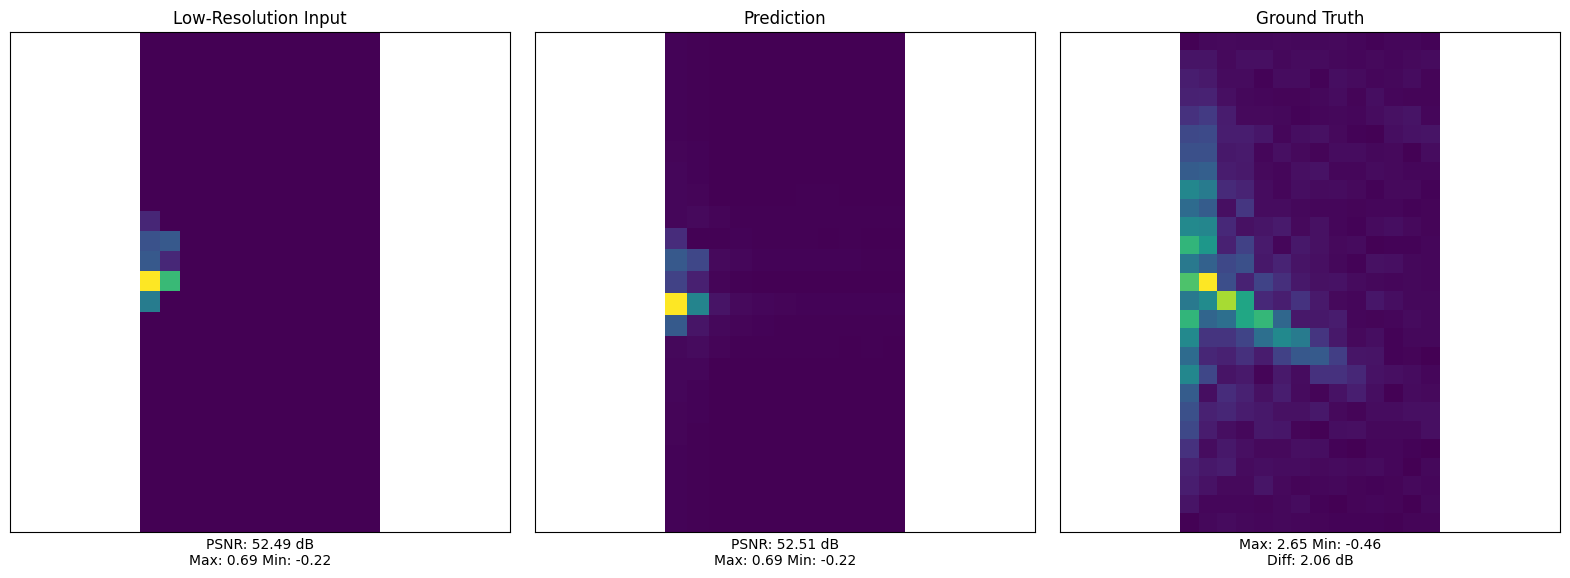

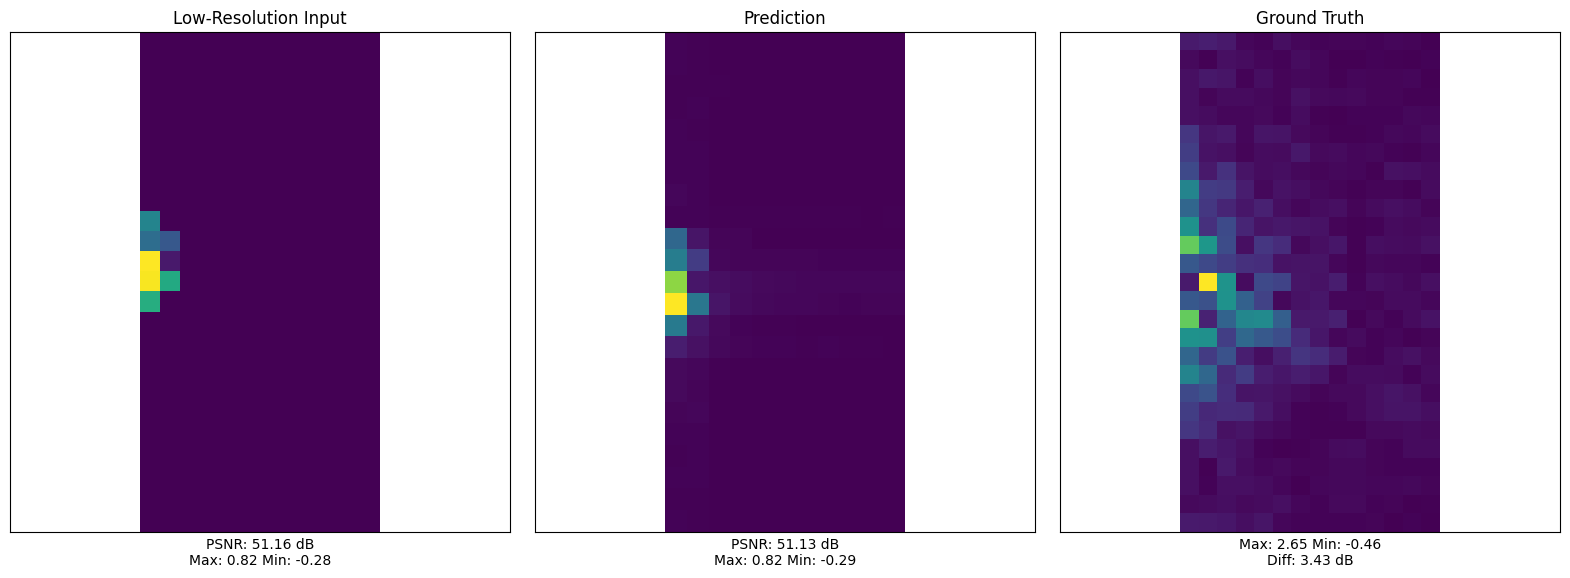

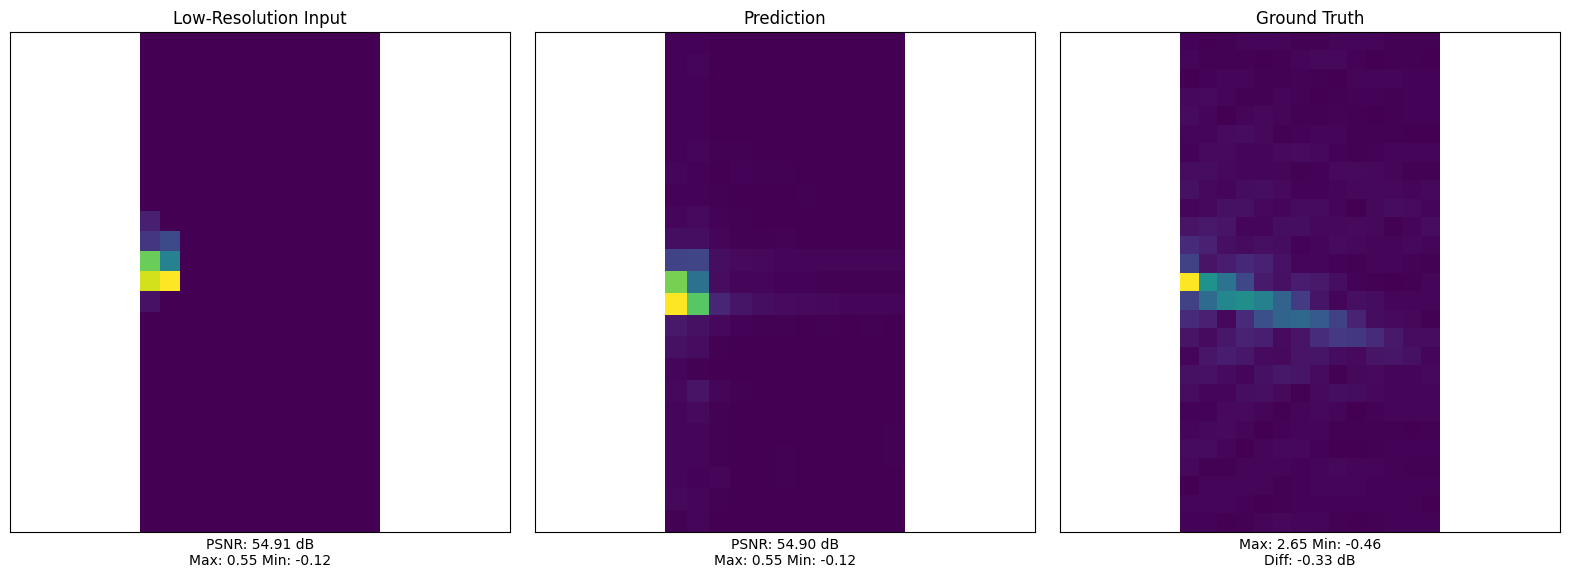

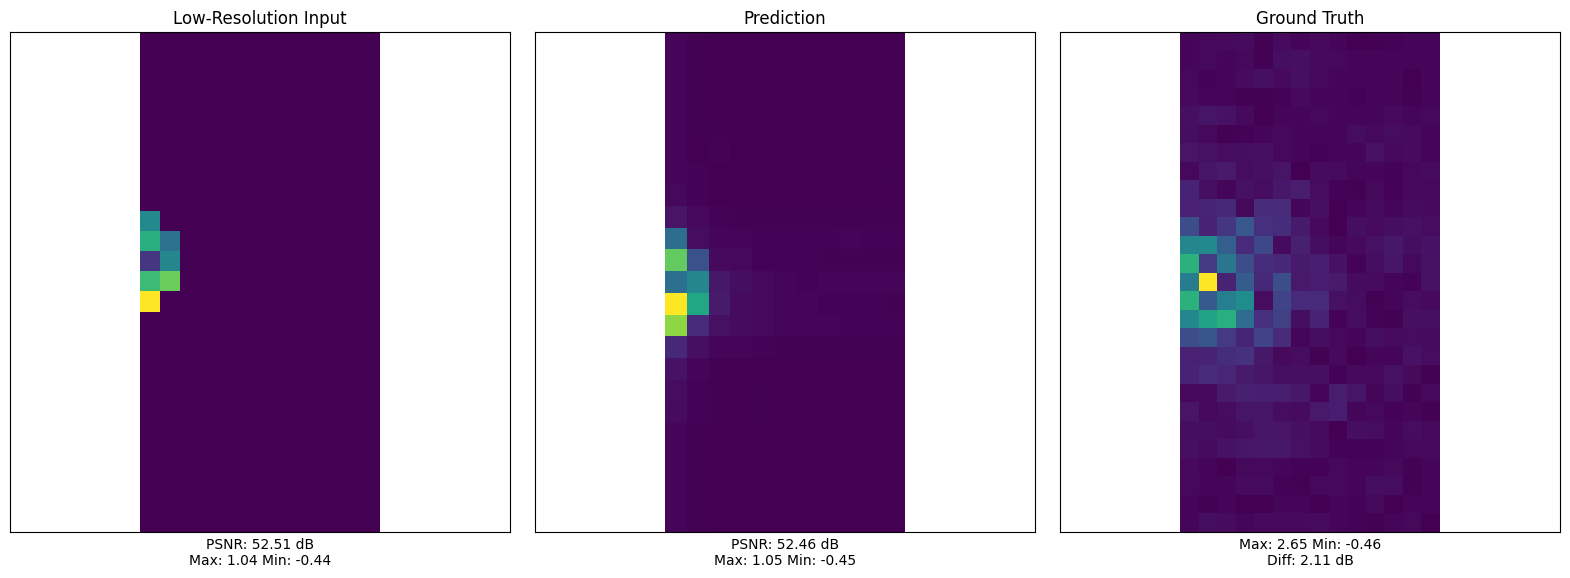

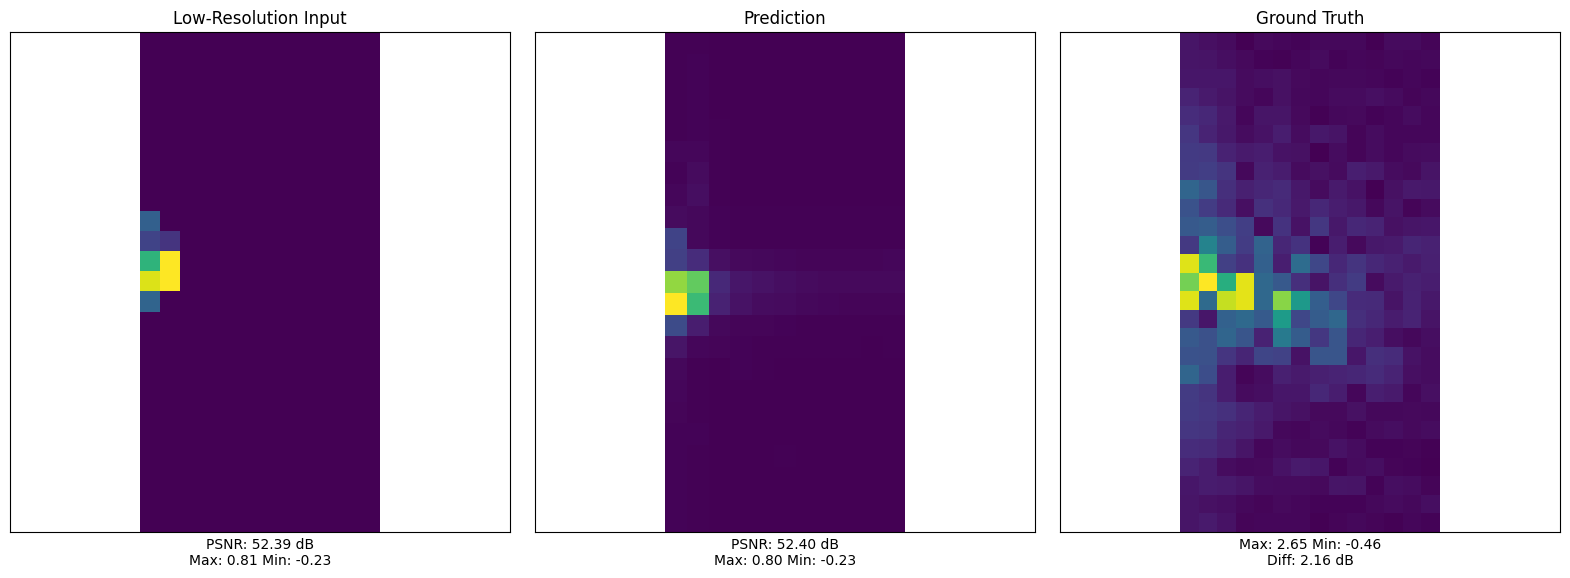

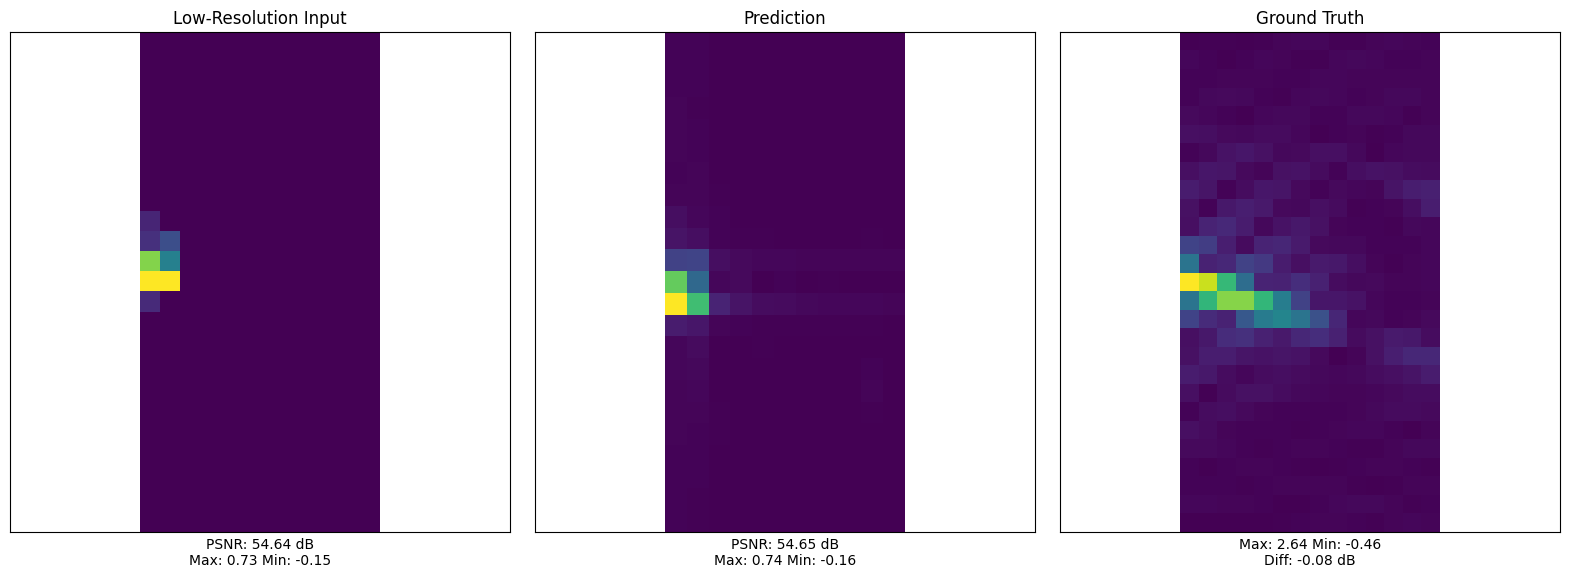

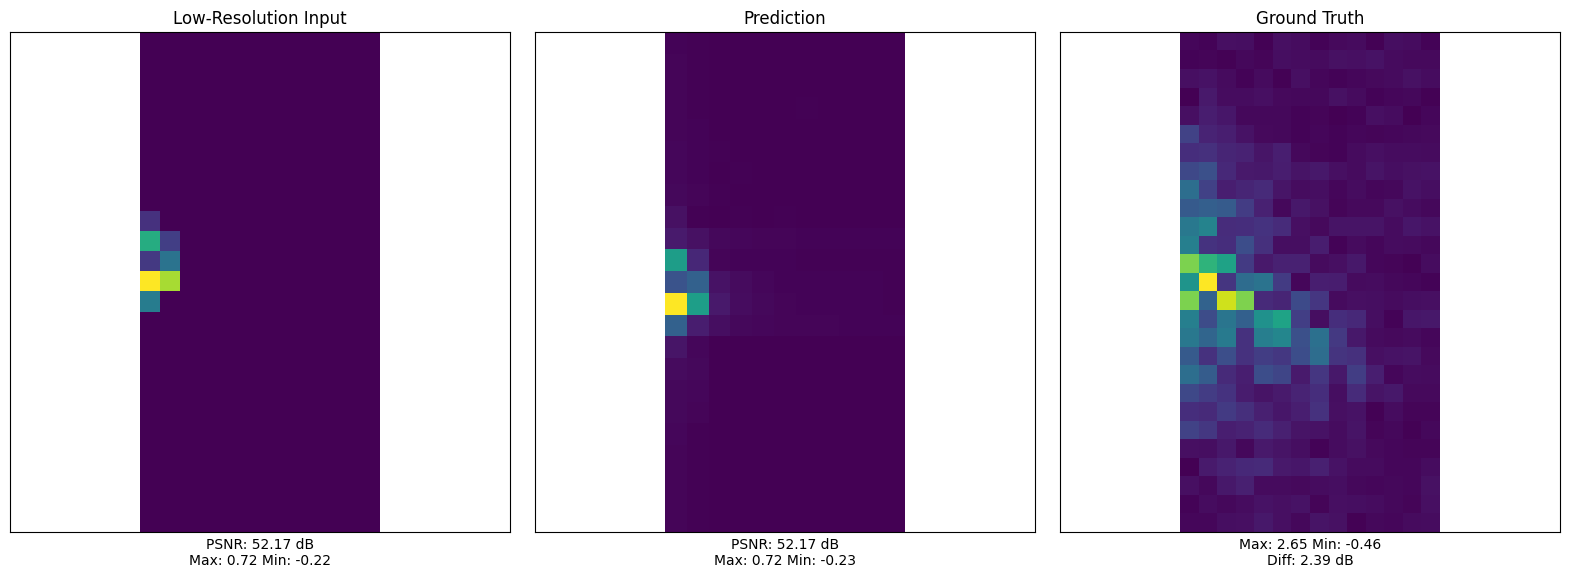

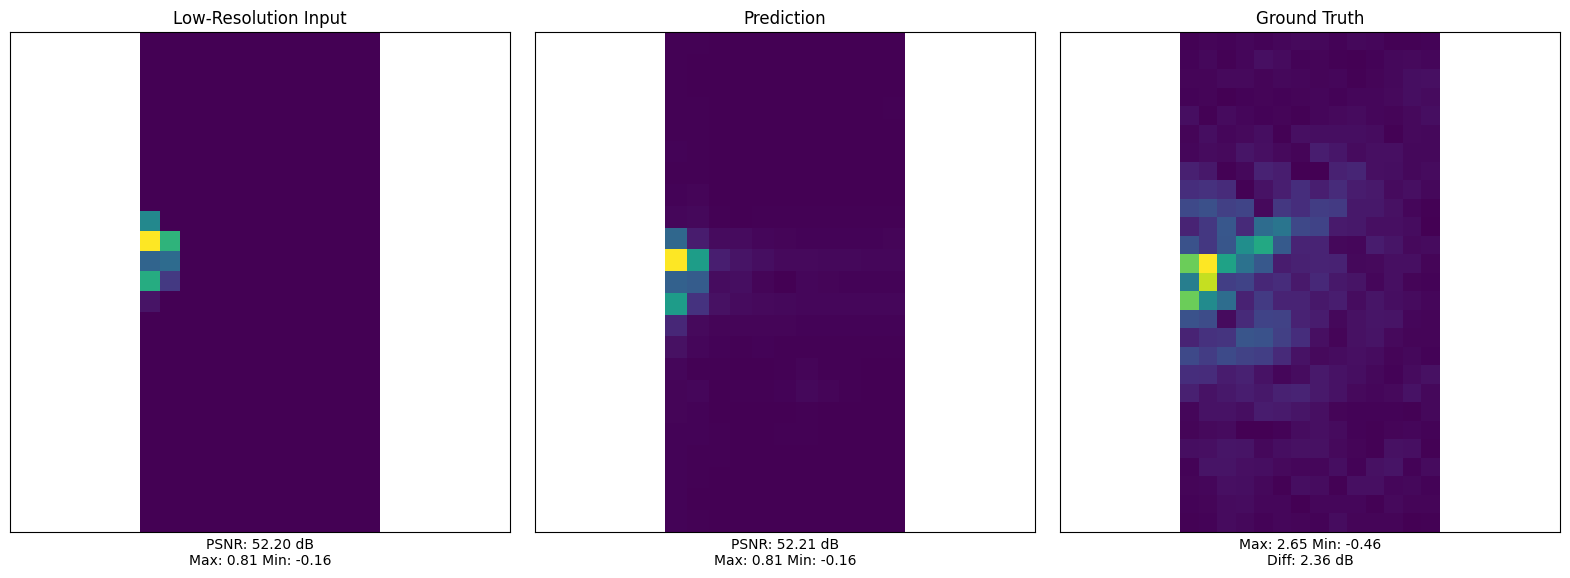

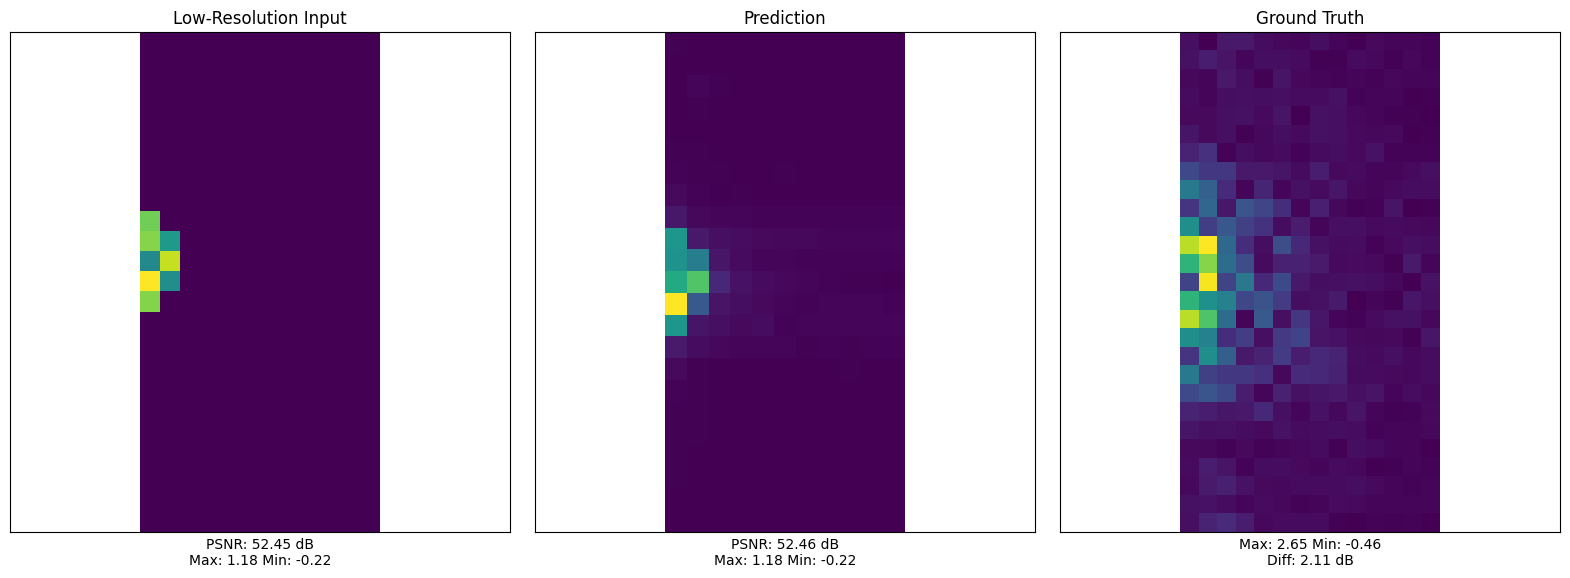

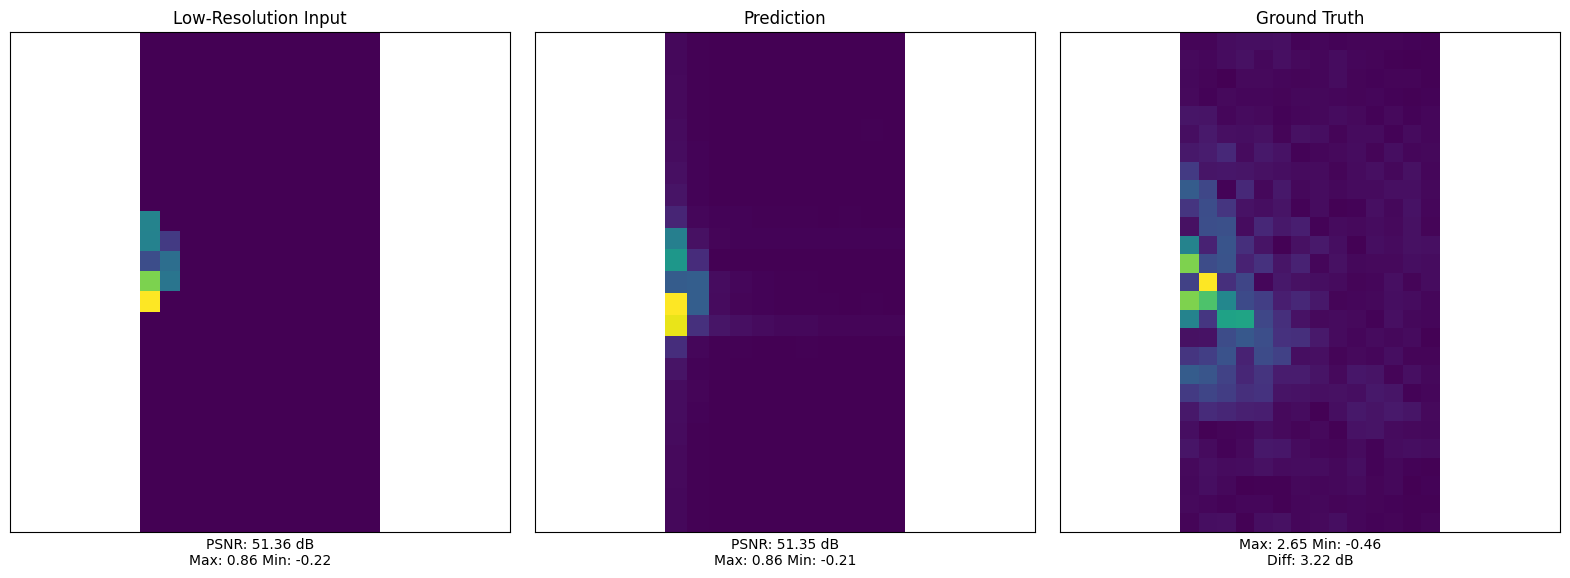

In [30]:
diff = []
lowres_scaled = torch.zeros_like(lowres)
pred_img_scaled = torch.zeros_like(pred_img)
for i in range(10):
    sample = i
    pred_img_scaled[i] = (pred_img[i] - gt[i].min())/(gt[i].max() - gt[i].min())
    lowres_scaled[i] = (lowres[i] - gt[i].min())/(gt[i].max() - gt[i].min())
    fig = plt.figure(figsize=(31/2., 10/2.))
    gs = gridspec.GridSpec(1, 5, width_ratios=[10,0.5, 10, 0.5, 10]) 
    ax0 = plt.subplot(gs[0])
    ax1 = plt.subplot(gs[2])
    ax2 = plt.subplot(gs[4])
    plt.subplots_adjust(top = 1, bottom = 0, right = 1, left = 0, 
                        hspace = 0, wspace = 0)
    ax0.xaxis.set_major_locator(plt.NullLocator())
    ax0.yaxis.set_major_locator(plt.NullLocator())
    lowres_scaled_vs_gt_psnr = PSNR(gt[sample][2:, 2:], lowres_scaled[sample][2:, 2:], drange=torch.tensor(255., dtype=torch.float32))
    ax0.imshow(np.roll(abs(torch.fft.rfftn(lowres[sample],dim = [0,1])),13,0)[2:, 2:])
    ax0.set_title('Low-Resolution Input');
    ax0.set_xlabel(f'PSNR: {lowres_scaled_vs_gt_psnr:.2f} dB\nMax: {lowres_scaled[sample].max():.2f} Min: {lowres_scaled[sample].min():.2f}');
    ax0.axis('equal');

    ax1.xaxis.set_major_locator(plt.NullLocator())
    ax1.yaxis.set_major_locator(plt.NullLocator())
    
    ax1.imshow(np.roll(abs(torch.fft.rfftn(pred_img[sample][2:, 2:],dim = [0,1])),13,0)[2:, 2:])
    pred_vs_gt_psnr = PSNR(gt[sample][2:, 2:], pred_img_scaled[sample][2:, 2:], drange=torch.tensor(255., dtype=torch.float32))
    ax1.set_title('Prediction');
    ax1.set_xlabel(f'PSNR: {pred_vs_gt_psnr:.2f} dB\nMax: {pred_img_scaled[sample].max():.2f} Min: {pred_img_scaled[sample].min():.2f}');
    ax1.axis('equal');

    ax2.xaxis.set_major_locator(plt.NullLocator())
    ax2.yaxis.set_major_locator(plt.NullLocator())
    ax2.imshow(np.roll(abs(torch.fft.rfftn(gt[sample],dim = [0,1])),13,0))
    ax2.set_title('Ground Truth');
    ax2.set_xlabel(f'Max: {gt[sample].max():.2f} Min: {gt[sample].min():.2f}\nDiff: {lowres_vs_gt_psnr - pred_vs_gt_psnr:.2f} dB');
    ax2.axis('equal');
    diff.append(lowres_vs_gt_psnr - pred_vs_gt_psnr)

